# Pre-procesamiento de datos sobre el segmento de distribución y asociados

In [1]:
import pandas as pd 
import numpy as np
import unidecode as ud
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from pprint import pprint
import re
from rapidfuzz import process
import matplotlib.pyplot as plt
import seaborn as sns

## Pre-procesamiento de *df_par_comuna_empresadx*

El *'df_par_comuna_empresadx'* está hecho a partir de la información proporcionada por Comisión Nacional de Energía a través de la NTCSD 2024. Realiza una clasificación sobre la densidad de clientes en el par Comuna-Empresa.

Las clasifica en 5 grupos posibles:

 - "EXTREMADAMENTE BAJA" 
 - "MUY BAJA"
 - "BAJA"
 - "MEDIA"
 - "ALTA"

Fuente de los datos: [Norma Técnica de Calidad de Servicio para Sistemas de Distribución](https://www.cne.cl/wp-content/uploads/2024/05/NTCSDx2024-1.pdf) (Anexo: Clasificación de redes)

In [2]:
# Densidad de clientes en el Par Comuna-Empresa de Distribución
df_par_comuna_empresadx = pd.read_excel("./Datos_Dx/Par-Comuna-EmpresaDx.xlsx", index_col=0, engine='openpyxl')


# Se modifican los nombres de columnas para aplicación del .merge
df_par_comuna_empresadx = df_par_comuna_empresadx.rename(columns={"COMUNA": "Comuna", 
                                                                  "EMPRESA": "Distribuidor",
                                                                  "DENSIDAD": "Densidad"})

# Se normalizan las columnas Comuna y Distribuidor
for col in ["Comuna", "Distribuidor"]:
    df_par_comuna_empresadx[col] = (df_par_comuna_empresadx[col].str.lower()                                             # Se vuelve minúscula
                                                                .apply(lambda x: ud.unidecode(x) if pd.notna(x) else x)  # Se eliminan acentos
                                                                .str.strip())                                            # Se eliminan espacios en blanco

# Diccionario de errores de comunas -> correcciones
comunas = {
    "treguaco": "trehuaco"
}

# Diccionario de errores de empresas -> correcciones
empresas = {
    "eec": "electrica colina",
    "tiltil": "electrica til til",
    "enel": "enel distribucion"
}

# Se corrigen los errores de tipografía
df_par_comuna_empresadx["Comuna"] = df_par_comuna_empresadx["Comuna"].replace(comunas)
df_par_comuna_empresadx["Distribuidor"] = df_par_comuna_empresadx["Distribuidor"].replace(empresas)

# Se crea un mapeo para complementar la columna Densidad en valores numéricos, a hacer uso más adelante
mapeo = {"EXTREMADAMENTE BAJA": 1, 
         "MUY BAJA": 2,
         "BAJA": 3,
         "MEDIA": 4,
         "ALTA": 5}

df_par_comuna_empresadx["Mapeo_Densidad"] = df_par_comuna_empresadx["Densidad"].map(mapeo)

# Se añaden manualmente los pares Comuna-Empresa que se encuentra en df_clientes_regulados_norm
# La forma de clasificarlos se resume en la sección 'Limpieza del df_clientes_regulados_norm'
nuevas = [
    {"Comuna": "alto biobio", "Distribuidor": "coelcha", "Densidad": "MUY BAJA", "Mapeo_Densidad": 2},
    {"Comuna": "bulnes", "Distribuidor": "cge", "Densidad": "EXTREMADAMENTE BAJA", "Mapeo_Densidad": 1},
    {"Comuna": "vilcun", "Distribuidor": "cge", "Densidad": "EXTREMADAMENTE BAJA", "Mapeo_Densidad": 1},
    {"Comuna": "putre", "Distribuidor": "coopersol", "Densidad": "EXTREMADAMENTE BAJA", "Mapeo_Densidad": 1},
    {"Comuna": "arica", "Distribuidor": "desa", "Densidad": "EXTREMADAMENTE BAJA", "Mapeo_Densidad": 1},
    {"Comuna": "camarones", "Distribuidor": "desa", "Densidad": "EXTREMADAMENTE BAJA", "Mapeo_Densidad": 1}
]

df_par_comuna_empresadx = pd.concat([df_par_comuna_empresadx, pd.DataFrame(nuevas)], ignore_index=True)

# Elementos únicos de comunas y empresas 
# df_par_comuna_empresadx
comuna_par_unique = set(df_par_comuna_empresadx["Comuna"].unique())
empresa_par_unique = set(df_par_comuna_empresadx["Distribuidor"].unique())

df_par_comuna_empresadx

,Comuna,Distribuidor,Densidad,Mapeo_Densidad
0,aisen,edelaysen,MUY BAJA,2
1,algarrobo,edecsa,EXTREMADAMENTE BAJA,1
2,algarrobo,litoral,BAJA,3
3,alhue,cge,EXTREMADAMENTE BAJA,1
4,alto biobio,frontel,EXTREMADAMENTE BAJA,1
...,...,...,...,...
479,bulnes,cge,EXTREMADAMENTE BAJA,1
480,vilcun,cge,EXTREMADAMENTE BAJA,1
481,putre,coopersol,EXTREMADAMENTE BAJA,1
482,arica,desa,EXTREMADAMENTE BAJA,1


### Se guardan los cambios realizados para su uso general

In [3]:
df_par_comuna_empresadx.to_excel("./Datos_Dx_procesados/Par-Comuna-EmpresaDx (procesados).xlsx", index=False, engine='openpyxl')

## Pre-procesamiento de *df_clientes*

El *'df_clientes'* está hecho a partir de la información proporcionada por El Coordinador a través de su base de datos pública. Los datos del consumo facturado corresponden al promedio mensual entre Junio 2024 y Junio 2025 según lo exigido en el Artículo 1-17 de la NTCSD 2024.

La razón de uso de este periodo (Junio 2024 - Junio 2025) se debe a que es la única base de datos con información sobre la comuna del punto de consumo (aunque no esté completa, faltando aproximadamente 1.000.000 de clientes sin información sobre la comuna).

Fuente de los datos: [Página web del Coordinador](https://www.coordinador.cl/mercados/documentos/transferencias-economicas-de-empresas-distribuidoras/catastro-clientes-usuarios-en-distribucion/catastro-2025/)

In [4]:
# Usuarios de la red de Distribución
df_clientes = pd.read_parquet("./NT-Art-1-17-06_2025-v1/2506_CUDx_V2.parquet")

In [5]:
# Se eliminan las columnas que no aportan información relevante
df_clientes = df_clientes.drop(columns=['ID_ClienteKey', 'Cliente_Rut_DV', 'ClienteContacto_CorreoElectronico', 
                                        'ClienteContacto_Telefono', 'ClienteSubsectorEconomico', 'ConexionBarra', 
                                        'ConexionPunto', 'CicloMedicionInicio', 'CicloMedicionTermino', 
                                        'ClienteAutorizacion', 'ClienteNombre_RazonSocial', 'ConexionTipoEmpalme'])

# Se crea columna id_usuario para identificar cada usuario de la red de distribución
df_clientes["id_usuario"] = range(len(df_clientes))

# Se modifican los nombres de columnas para aplicación del .merge
df_clientes = df_clientes.rename(columns={"ConsumoComuna": "Comuna", 
                                          "ID_Distribuidor": "Distribuidor"})

# Se normalizan las columnas Comuna y Distribuidor
for col in ["Comuna", "Distribuidor"]:
    df_clientes[col] = (df_clientes[col].str.lower()                                             # Se vuelve minúscula
                                        .apply(lambda x: ud.unidecode(x) if pd.notna(x) else x)  # Se eliminan acentos
                                        .str.strip())                                            # Se eliminan espacios en blanco
    
# Se reemplaza "cabo de hornos (ex - navarino)" por "cabo de hornos" en la columna "Comuna"
df_clientes["Comuna"] = df_clientes["Comuna"].replace("cabo de hornos (ex - navarino)", "cabo de hornos")

# Se reellenan los nulos para la distribuidora "electrica colina", cuyo único suministro es en la comuna "colina"
df_clientes.loc[(df_clientes["Distribuidor"] == "electrica colina") & (df_clientes["Comuna"].isna()), "Comuna"] = "colina"

# Se eliminan registros que sean, alumbrado público o similares
df_clientes = df_clientes[~df_clientes["ConsumoTipoConsumo"].isin(["Utilidad Publica", "Alumbrado Público", "Semáforo"])]

# Se elimina el resto de los registros que contienen nulos en la Comuna
df_clientes_norm = df_clientes.dropna(subset=["Comuna"]).copy()
df_clientes_norm

,Distribuidor,EmpalmeCodigo,ClienteVigencia,ClienteCalidadJuridica,Comuna,ConsumoTipoUsuario,ConsumoTipoConsumo,ConsumoTipoSuministro,ConsumoTipoTarifa,ConsumoTension,ConsumoPotencia,ConsumoFacturado,ConexionAlimentador,ConexionSubestacionPrimariaDistribucion,id_usuario
0,edelmag,101693682,Activo,Persona Natural,natales,Cliente Exclusivo Regulado,Residencial,Cliente Regulado,BT1a,0.22kV,0.0,44.355,ALIMENTADOR 2 6,PUERTO NATALES,0
1,edelmag,101693682,Activo,Persona Natural,natales,Cliente Exclusivo Regulado,Residencial,Cliente Regulado,BT1a,0.22kV,0.0,10.645,ALIMENTADOR 2 6,PUERTO NATALES,1
2,edelmag,101694022,Activo,Persona Natural,natales,Cliente Exclusivo Regulado,Residencial,Cliente Regulado,BT1a,0.22kV,0.0,1.936,ALIMENTADOR 2 4,PUERTO NATALES,2
3,edelmag,101694024,Activo,Persona Natural,natales,Cliente Exclusivo Regulado,Residencial,Cliente Regulado,BT1a,0.22kV,0.0,4.167,ALIMENTADOR 2 4,PUERTO NATALES,3
4,edelmag,101836414,Activo,Persona Natural,natales,Cliente Exclusivo Regulado,Residencial,Cliente Regulado,BT1a,0.22kV,0.0,92.742,ALIMENTADOR 2 2,PUERTO NATALES,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7951469,electrica til til,56229,Activo,Persona Natural,tiltil,Cliente Exclusivo Regulado,Residencial,Cliente Regulado,BT1a,23kV,16.0,709.000,RUNGUE,RUNGUE,7951469
7951470,electrica til til,56232,Activo,Persona Natural,tiltil,Cliente Exclusivo Regulado,Residencial,Cliente Regulado,BT1a,23kV,3.0,275.000,TILTIL,POLPAICO (ENEL),7951470
7951471,electrica til til,56233,Activo,Persona Natural,tiltil,Cliente Exclusivo Regulado,Residencial,Cliente Regulado,BT1a,23kV,32.0,0.000,TILTIL,POLPAICO (ENEL),7951471
7951472,electrica til til,56244,Activo,Persona Natural,tiltil,Cliente Exclusivo Regulado,Residencial,Cliente Regulado,BT1a,13kV,15.0,17.000,CALEU,CALEU,7951472


### Se guardan los cambios realizados para su uso general

In [7]:
df_clientes.to_parquet("./Datos_Dx_procesados/ClientesDx.parquet", index=False)

### Rellenado de comunas a través de la infomación de ConexionAlimentador

In [6]:
df_clientes_sin_comuna = df_clientes[~df_clientes["id_usuario"].isin(df_clientes_norm["id_usuario"])]
df_clientes_sin_comuna = df_clientes_sin_comuna.dropna(subset=["ConexionAlimentador"]).copy()

# Rellenado de la columna Comuna en df_clientes_sin_comuna a traves de la columna ConexionAlimentador
df_comuna_alimentadores = pd.DataFrame(columns=["Comuna", "ConexionAlimentador"])

for comuna in df_clientes_norm["Comuna"].unique():
    Alimentadores = df_clientes_norm.loc[df_clientes_norm["Comuna"] == comuna, "ConexionAlimentador"].unique()
    for alimentador in Alimentadores:
        df_comuna_alimentadores = pd.concat([df_comuna_alimentadores, pd.DataFrame({"Comuna": [comuna], "ConexionAlimentador": [alimentador]})], ignore_index=True)

df_comuna_alimentadores = df_comuna_alimentadores.dropna().copy()

unicos = (df_comuna_alimentadores.groupby("ConexionAlimentador")["Comuna"]
                     .unique()
                     .reset_index())

# Filtrar solo los que aparecen en exactamente una comuna
unicos = unicos[unicos["Comuna"].str.len() == 1]
unicos["Comuna"] = unicos["Comuna"].str[0]

lista_norm = np.array(unicos['ConexionAlimentador'])
lista_sin_comuna = np.array(df_clientes_sin_comuna['ConexionAlimentador'].unique())

# Se estudia la coincidencia entre lista_norm y lista_sin_comuna
alimentadores_a_comparar = set(lista_norm).intersection(set(lista_sin_comuna))

filtrados = unicos[unicos["ConexionAlimentador"].isin(alimentadores_a_comparar)].copy()

mapa = (filtrados[["ConexionAlimentador", "Comuna"]]
        .set_index("ConexionAlimentador")["Comuna"])

# Crear (o rellenar) la columna Comuna en df_clientes_sin_comuna
df_clientes_sin_comuna["Comuna"] = df_clientes_sin_comuna["ConexionAlimentador"].map(mapa)

df_clientes_sin_comuna_rellenado = df_clientes_sin_comuna.dropna(subset=["Comuna"]).copy()
df_clientes_sin_comuna = df_clientes_sin_comuna[~df_clientes_sin_comuna["id_usuario"].isin(df_clientes_sin_comuna_rellenado["id_usuario"])]

df_clientes_norm = pd.concat([df_clientes_norm, df_clientes_sin_comuna_rellenado], ignore_index=True)
df_clientes_norm

,Distribuidor,EmpalmeCodigo,ClienteVigencia,ClienteCalidadJuridica,Comuna,ConsumoTipoUsuario,ConsumoTipoConsumo,ConsumoTipoSuministro,ConsumoTipoTarifa,ConsumoTension,ConsumoPotencia,ConsumoFacturado,ConexionAlimentador,ConexionSubestacionPrimariaDistribucion,id_usuario
0,edelmag,101693682,Activo,Persona Natural,natales,Cliente Exclusivo Regulado,Residencial,Cliente Regulado,BT1a,0.22kV,0.0,44.35500,ALIMENTADOR 2 6,PUERTO NATALES,0
1,edelmag,101693682,Activo,Persona Natural,natales,Cliente Exclusivo Regulado,Residencial,Cliente Regulado,BT1a,0.22kV,0.0,10.64500,ALIMENTADOR 2 6,PUERTO NATALES,1
2,edelmag,101694022,Activo,Persona Natural,natales,Cliente Exclusivo Regulado,Residencial,Cliente Regulado,BT1a,0.22kV,0.0,1.93600,ALIMENTADOR 2 4,PUERTO NATALES,2
3,edelmag,101694024,Activo,Persona Natural,natales,Cliente Exclusivo Regulado,Residencial,Cliente Regulado,BT1a,0.22kV,0.0,4.16700,ALIMENTADOR 2 4,PUERTO NATALES,3
4,edelmag,101836414,Activo,Persona Natural,natales,Cliente Exclusivo Regulado,Residencial,Cliente Regulado,BT1a,0.22kV,0.0,92.74200,ALIMENTADOR 2 2,PUERTO NATALES,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6852378,saesa,<NA>,<NA>,<NA>,combarbala,Cliente Exclusivo Regulado,<NA>,<NA>,<NA>,23kV,6.0,237.41667,CIUDAD,QUELLON,7879711
6852379,saesa,<NA>,<NA>,<NA>,combarbala,Cliente Exclusivo Regulado,<NA>,<NA>,<NA>,23kV,6.0,113.16667,CIUDAD,QUELLON,7879712
6852380,saesa,<NA>,<NA>,<NA>,combarbala,Cliente Exclusivo Regulado,<NA>,<NA>,<NA>,23kV,6.0,51.83333,CIUDAD,QUELLON,7879713
6852381,saesa,<NA>,<NA>,<NA>,combarbala,Cliente Exclusivo Regulado,<NA>,<NA>,<NA>,23kV,6.0,458.83333,CIUDAD,QUELLON,7879714


### Rellenado de comunas a través de la infomación de ConexionSubestacionPrimariaDistribucion

In [7]:
df_clientes_sin_comuna = df_clientes[~df_clientes["id_usuario"].isin(df_clientes_norm["id_usuario"])]
df_clientes_sin_comuna = df_clientes_sin_comuna.dropna(subset=["ConexionSubestacionPrimariaDistribucion"]).copy()

# Obtener los valores únicos de Comuna y ConexionSubestacionPrimariaDistribucion
df_comuna_subestacion = pd.DataFrame(columns=["Comuna", "ConexionSubestacionPrimariaDistribucion"])

for comuna in df_clientes_norm["Comuna"].unique():
    subestacion = df_clientes_norm.loc[df_clientes_norm["Comuna"] == comuna, "ConexionSubestacionPrimariaDistribucion"].unique()
    for sub in subestacion:
        df_comuna_subestacion = pd.concat([df_comuna_subestacion, pd.DataFrame({"Comuna": [comuna], "ConexionSubestacionPrimariaDistribucion": [sub]})], ignore_index=True)

df_comuna_subestacion = df_comuna_subestacion.dropna().copy()

unicos = (df_comuna_subestacion.groupby("ConexionSubestacionPrimariaDistribucion")["Comuna"]
                     .unique()
                     .reset_index())

# Filtrar solo los que aparecen en exactamente una comuna
unicos = unicos[unicos["Comuna"].str.len() == 1]
unicos["Comuna"] = unicos["Comuna"].str[0]
unicos

lista_norm = np.array(unicos['ConexionSubestacionPrimariaDistribucion'])
lista_sin_comuna = np.array(df_clientes_sin_comuna['ConexionSubestacionPrimariaDistribucion'].unique())

# Se estudia la coincidencia entre lista_norm y lista_sin_comuna
subestaciones_a_comparar = set(lista_norm).intersection(set(lista_sin_comuna))

filtrados = unicos[unicos["ConexionSubestacionPrimariaDistribucion"].isin(subestaciones_a_comparar)].copy()

mapa = (filtrados[["ConexionSubestacionPrimariaDistribucion", "Comuna"]]
        .set_index("ConexionSubestacionPrimariaDistribucion")["Comuna"])

# Crear (o rellenar) la columna Comuna en df_clientes_sin_comuna
df_clientes_sin_comuna["Comuna"] = df_clientes_sin_comuna["ConexionSubestacionPrimariaDistribucion"].map(mapa)
df_clientes_sin_comuna

df_clientes_sin_comuna_rellenado = df_clientes_sin_comuna.dropna(subset=["Comuna"]).copy()
df_clientes_sin_comuna_rellenado
df_clientes_sin_comuna = df_clientes_sin_comuna[~df_clientes_sin_comuna["id_usuario"].isin(df_clientes_sin_comuna_rellenado["id_usuario"])]

df_clientes_norm = pd.concat([df_clientes_norm, df_clientes_sin_comuna_rellenado], ignore_index=True)
df_clientes_norm

,Distribuidor,EmpalmeCodigo,ClienteVigencia,ClienteCalidadJuridica,Comuna,ConsumoTipoUsuario,ConsumoTipoConsumo,ConsumoTipoSuministro,ConsumoTipoTarifa,ConsumoTension,ConsumoPotencia,ConsumoFacturado,ConexionAlimentador,ConexionSubestacionPrimariaDistribucion,id_usuario
0,edelmag,101693682,Activo,Persona Natural,natales,Cliente Exclusivo Regulado,Residencial,Cliente Regulado,BT1a,0.22kV,0.0,44.35500,ALIMENTADOR 2 6,PUERTO NATALES,0
1,edelmag,101693682,Activo,Persona Natural,natales,Cliente Exclusivo Regulado,Residencial,Cliente Regulado,BT1a,0.22kV,0.0,10.64500,ALIMENTADOR 2 6,PUERTO NATALES,1
2,edelmag,101694022,Activo,Persona Natural,natales,Cliente Exclusivo Regulado,Residencial,Cliente Regulado,BT1a,0.22kV,0.0,1.93600,ALIMENTADOR 2 4,PUERTO NATALES,2
3,edelmag,101694024,Activo,Persona Natural,natales,Cliente Exclusivo Regulado,Residencial,Cliente Regulado,BT1a,0.22kV,0.0,4.16700,ALIMENTADOR 2 4,PUERTO NATALES,3
4,edelmag,101836414,Activo,Persona Natural,natales,Cliente Exclusivo Regulado,Residencial,Cliente Regulado,BT1a,0.22kV,0.0,92.74200,ALIMENTADOR 2 2,PUERTO NATALES,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6869716,saesa,<NA>,<NA>,<NA>,combarbala,Cliente Exclusivo Regulado,<NA>,<NA>,<NA>,23kV,6.0,384.37500,<NA>,QUELLON,7879715
6869717,saesa,<NA>,<NA>,<NA>,combarbala,Cliente Exclusivo Regulado,<NA>,<NA>,<NA>,23kV,6.0,62.83333,<NA>,QUELLON,7879717
6869718,saesa,<NA>,<NA>,<NA>,combarbala,Cliente Exclusivo Regulado,<NA>,<NA>,<NA>,23kV,6.0,115.44444,<NA>,QUELLON,7879718
6869719,saesa,<NA>,<NA>,<NA>,combarbala,Cliente Exclusivo Regulado,<NA>,<NA>,<NA>,23kV,6.0,153.00000,LADRILLEROS,QUELLON,7879719


In [25]:
# Se extraen los pares Comuna-Subestación únicos
df_se_tabla = (
    df_comuna_subestacion
    .dropna(subset=["ConexionSubestacionPrimariaDistribucion"])
    .drop_duplicates(subset=["ConexionSubestacionPrimariaDistribucion"])
)

df_se_por_comuna = (
    df_se_tabla
    .groupby("Comuna")["ConexionSubestacionPrimariaDistribucion"]
    .nunique()                         # cuenta SE distintas por comuna
    .reset_index(name="Cantidad_SPD")   # renombra la columna de conteo
)

df_se_por_comuna

,Comuna,Cantidad_SPD
0,alhue,2
1,alto del carmen,2
2,andacollo,2
3,antofagasta,12
4,arica,4
...,...,...
113,vichuquen,2
114,vicuna,1
115,villarrica,1
116,vina del mar,7


### Se guardan los cambios realizados para su uso general

In [26]:
df_clientes_norm.to_parquet("./Datos_Dx_procesados/ClientesDx_normalizados (procesados).parquet", index=False)
df_se_por_comuna.to_excel("./Datos_Dx_procesados/Cantidad_SE_por_Comuna.xlsx", index=False, engine='openpyxl')

## Pre-procesamiento de *df_facturacion_clientes_regulados*

El *'df_facturacion_clientes_regulados'* está hecho a partir de la información proporcionada por la plataforma Energía Abierta a través de su base de datos pública. Los datos de consumo se encuentran actualizados a diciembre del 2024.

Fuente de los datos: [Página web energía abierta](http://energiaabierta.cl/categorias-estadistica/electricidad/)

In [4]:
# Se cargan los datos de facturación de clientes regulados
df_facturacion_clientes_regulados = pd.read_excel("./Datos_Dx/se_facturacion_clientes_regulados.xlsx")

In [ ]:
# Se modifican los nombres de columnas para aplicación del .merge
df_facturacion_clientes_regulados = df_facturacion_clientes_regulados.rename(columns={"tarifa": "Tipo_de_tarifa", 
                                                                                      "clientes_facturados": "Cantidad_de_clientes",
                                                                                      "energia_kwh": "Energia_total_kwh"})

# Se eliminan las columnas que no se usarán
df_facturacion_clientes_regulados = df_facturacion_clientes_regulados.drop(columns=["e1_kwh", "e2_kwh"])

# Se normalizan las columnas Comuna y Region
for col in ["Region", "Comuna", "Tipo_de_tarifa"]:
    df_facturacion_clientes_regulados[col] = (df_facturacion_clientes_regulados[col].str.lower()                # Se vuelve minúscula
                                                    .apply(lambda x: ud.unidecode(x) if pd.notna(x) else x)     # Se eliminan acentos
                                                    .str.strip())                                               # Se eliminan espacios en blanco

# Se filtra el df para considerar solo los datos del año 2024 (año más actualizado)
df_facturacion_clientes_regulados = df_facturacion_clientes_regulados[df_facturacion_clientes_regulados["Año"] == 2024]
df_facturacion_clientes_regulados_mes_12 = df_facturacion_clientes_regulados[df_facturacion_clientes_regulados["Mes"] == 12]
df_facturacion_clientes_regulados

In [ ]:
# Se corrigen algunos de los errores en la columna de la Comuna
def mejor_match(nombre, lista_oficial):
    match, score, _ = process.extractOne(nombre, lista_oficial)
    return match if score > 80 else None

df_facturacion_clientes_regulados["Comuna_1"] = df_facturacion_clientes_regulados["Comuna"].apply(lambda x: mejor_match(x, comuna_par_unique))
df_facturacion_clientes_regulados["Comuna_1"] = df_facturacion_clientes_regulados["Comuna_1"].fillna(df_facturacion_clientes_regulados["Comuna"])

# Diccionario de errores -> correcciones
correcciones_comuna = {
    "a'iqua(c)n": "niquen",
    "a'ua+-oa": "nunoa",
    "aisa(c)n": "aisen",
    "alhua(c)": "alhue",
    "caa+-ete": "canete",
    "chaa+-aral": "chanaral",
    "chaita(c)n": "chaiten",
    "cochama3": "cochamo",
    "colbaon": "colbun",
    "conca3n": "concon",
    "copiapa3": "copiapo",
    "curica3": "curico",
    "doa+-ihue": "donihue",
    "vicua+-a": "vicuna",
    "hualaa+-a(c)": "hualane",
    "hualaihua(c)": "hualaihue",
    "hualpa(c)n": "hualpen",
    "licanta(c)n": "licanten",
    "mulcha(c)n": "mulchen",
    "olmua(c)": "olmue",
    "pea+-aflor": "penaflor",
    "pea+-alola(c)n": "penalolen",
    "pitrufqua(c)n": "pitrufquen",
    "puca3n": "pucon",
    "pura(c)n": "puren",
    "queila(c)n": "queilen",
    "quella3n": "quellon",
    "quilla3n": "quillon",
    "quilpua(c)": "quilpue",
    "rao iba!a+-ez": "rio ibanez",
    "tiraoa": "tirua",
    "tolta(c)n": "tolten",
    "toma(c)": "tome",
    "traigua(c)n": "traiguen",
    "vichuqua(c)n": "vichuquen",
    "vilcaon": "vilcun",
}

correcciones_region = {
    "regia3n metropolitana de santiago": "region metropolitana de santiago",
    "regia3n de valparaaso": "region de valparaiso",
    "regia3n del biobao": "region del biobio",
    "regia3n del libertador gral. bernardo oaEUR(tm)higgins": "region del libertador general bernardo ohiggins",
    "regia3n de la araucanaa": "region de la araucania",
    "regia3n de los lagos": "region de los lagos",
    "regia3n del maule": "region del maule",
    "regia3n de a'uble": "region de nuble",
    "regia3n de coquimbo": "region de coquimbo",
    "regia3n de los raos": "region de los rios",
    "regia3n de atacama": "region de atacama",
    "regia3n aisa(c)n del gral.carlos iba!a+-ez del campo": "region de aysen del general carlos ibanez del campo",
    "regia3n de antofagasta": "region de antofagasta",
    "regia3n de tarapaca!": "region de tarapaca",
    "regia3n de magallanes y de la anta!rtica chilena": "region de magallanes y de la antartica chilena",
    "regia3n de arica y parinacota": "region de arica y parinacota"
}

# Se aplican los reemplazos
df_facturacion_clientes_regulados["Comuna_1"] = df_facturacion_clientes_regulados["Comuna_1"].replace(correcciones_comuna)
df_facturacion_clientes_regulados["Comuna"] = df_facturacion_clientes_regulados["Comuna_1"]
df_facturacion_clientes_regulados["Region"] = df_facturacion_clientes_regulados["Region"].replace(correcciones_region)
df_facturacion_clientes_regulados = df_facturacion_clientes_regulados.drop(columns=["Comuna_1"])

In [ ]:
# Se filtran los clientes residenciales y no residenciales
df_facturacion_clientes_residenciales = df_facturacion_clientes_regulados[df_facturacion_clientes_regulados["tipo_clientes"] == "Residencial"].copy()
df_facturacion_clientes_no_residenciales = df_facturacion_clientes_regulados[df_facturacion_clientes_regulados['tipo_clientes'] == 'No Residencial']

# Se agrupan los registros por comuna y se suman las demás columnas numéricas
df_facturacion_clientes_residenciales = df_facturacion_clientes_residenciales.groupby(["Año", "Mes", "Region", "Comuna", "tipo_clientes"], 
                                                                                       as_index=False).agg({"Cantidad_de_clientes": "sum",
                                                                                                            "Energia_total_kwh": "sum"})

# Se agrupan los registros por comuna y se suman las demás columnas numéricas
df_facturacion_clientes_no_residenciales = df_facturacion_clientes_no_residenciales.groupby(["Año", "Mes", "Region", "Comuna", "tipo_clientes"], 
                                                                                       as_index=False).agg({"Cantidad_de_clientes": "sum",
                                                                                                            "Energia_total_kwh": "sum"})

# Se combinan ambos dataframes
df_facturacion_clientes_regulados = pd.concat([df_facturacion_clientes_residenciales, df_facturacion_clientes_no_residenciales], ignore_index=True)

In [ ]:
# Se filtran los clientes residenciales y no residenciales
df_facturacion_clientes_residenciales = df_facturacion_clientes_regulados[df_facturacion_clientes_regulados["tipo_clientes"] == "Residencial"].copy()
df_facturacion_clientes_no_residenciales = df_facturacion_clientes_regulados[df_facturacion_clientes_regulados['tipo_clientes'] == 'No Residencial']

# Se agrupan los registros por comuna y se suman las demás columnas numéricas
df_facturacion_clientes_residenciales = df_facturacion_clientes_residenciales.groupby(["Año", "Mes", "Region", "Comuna", "tipo_clientes"], 
                                                                                       as_index=False).agg({"Cantidad_de_clientes": "sum",
                                                                                                            "Energia_total_kwh": "sum"})

# Se agrupan los registros por comuna y se suman las demás columnas numéricas
df_facturacion_clientes_no_residenciales = df_facturacion_clientes_no_residenciales.groupby(["Año", "Mes", "Region", "Comuna", "tipo_clientes"], 
                                                                                       as_index=False).agg({"Cantidad_de_clientes": "sum",
                                                                                                            "Energia_total_kwh": "sum"})

# Se combinan ambos dataframes
df_facturacion_clientes_regulados = pd.concat([df_facturacion_clientes_residenciales, df_facturacion_clientes_no_residenciales], ignore_index=True)


# Promedio mensual de la energía consumida total entre los clientes regulados para el año 2024
df_facturacion_clientes_regulados_prom = pd.DataFrame()

comunas_unicas = df_facturacion_clientes_regulados["Comuna"].unique()
Tipos_clientes = df_facturacion_clientes_regulados["tipo_clientes"].unique()
for comuna in comunas_unicas:
    for tipo in Tipos_clientes:
        df_filtro = df_facturacion_clientes_regulados[(df_facturacion_clientes_regulados["Comuna"] == comuna) & 
                                                      (df_facturacion_clientes_regulados["tipo_clientes"] == tipo)]
        
        cantidad_de_clientes = df_filtro.loc[df_filtro["Mes"] == 12, "Cantidad_de_clientes"].values[0]
        energia_promedio_mensual = (df_filtro["Energia_total_kwh"].sum() / 12).round(2)

        nuevo_registro = {
            "Año": 2024,
            "Region": df_filtro.iloc[0]["Region"],
            "Comuna": comuna,
            "Tipo_clientes": tipo,
            "Cantidad_de_clientes": cantidad_de_clientes,
            "Energia_promedio_mensual_2024_kWh": energia_promedio_mensual
        }
        df_facturacion_clientes_regulados_prom = pd.concat([df_facturacion_clientes_regulados_prom, pd.DataFrame([nuevo_registro])], ignore_index=True)

df_facturacion_clientes_regulados_prom

In [ ]:
# df_facturacion_clientes_regulados
comuna_clientes_unique = set(df_facturacion_clientes_regulados_prom["Comuna"].unique())

# Comunas en los que difieren en ambos dataframes
comunas_distintas = comuna_par_unique.symmetric_difference(comuna_clientes_unique)

print(" Cantidad de Comunas evaluadas en df_facturación_clientes_regulados: ", len(comuna_clientes_unique), 
      "\n Cantidad de Comunas existentes según información de la CNE: ", len(comuna_par_unique),
      "\n -> Cantidad de comunas distintas: ", len(comunas_distintas),
      "\n -> Comunas distintas: ", sorted(comunas_distintas))

### Resultados generales sobre Cantidad de Clientes y Energía Consumida

In [ ]:
# Información al mes de diciembre de 2024
# -> Cantidad de clientes.
# -> Cantidad de energía.
cantidad_clientes_regulados = df_facturacion_clientes_regulados_prom['Cantidad_de_clientes'].sum()
cantidad_energia_regulados = df_facturacion_clientes_regulados_prom['Energia_promedio_mensual_2024_kWh'].sum()

df_facturacion_clientes_residenciales = df_facturacion_clientes_regulados_prom[df_facturacion_clientes_regulados_prom['Tipo_clientes'] == 'Residencial']
cantidad_clientes_residenciales = df_facturacion_clientes_residenciales['Cantidad_de_clientes'].sum()
cantidad_energia_residenciales = df_facturacion_clientes_residenciales['Energia_promedio_mensual_2024_kWh'].sum()

df_facturacion_clientes_no_residenciales = df_facturacion_clientes_regulados_prom[df_facturacion_clientes_regulados_prom['Tipo_clientes'] == 'No Residencial']
cantidad_clientes_no_residenciales = df_facturacion_clientes_no_residenciales['Cantidad_de_clientes'].sum()
cantidad_energia_no_residenciales = df_facturacion_clientes_no_residenciales['Energia_promedio_mensual_2024_kWh'].sum()

print("(A fecha de diciembre de 2024)",
      "\nClientes regulados:", 
      "\n -> Cantidad de clientes: {:,}".format(cantidad_clientes_regulados), 
      "\n -> Energía facturada: {:,} TWh".format((cantidad_energia_regulados / 1_000_000_000).round(2)),
      "\nClientes residenciales:",
      "\n -> Cantidad de clientes: {:,}".format(cantidad_clientes_residenciales),
      "\n -> Energía facturada: {:,} TWh".format((cantidad_energia_residenciales / 1_000_000_000).round(2)),
      "\nCantidad de clientes no residenciales:",
      "\n -> Cantidad de clientes: {:,}".format(cantidad_clientes_no_residenciales),
      "\n -> Energía facturada: {:,} TWh".format((cantidad_energia_no_residenciales / 1_000_000_000).round(2)))

### Se guardan los cambios realizados para su uso en *Caracterizacion_Dx_Dic2024_por_comuna(EA).ipynb*

In [ ]:
df_facturacion_clientes_regulados_prom.to_excel("./Datos_Dx_procesados/se_facturacion_clientes_regulados (procesados).xlsx", index=False)

## Pre-procesamiento de *df_clientes_regulados*

El *'df_clientes_regulados'* está hecho a partir de la información proporcionada por la Comisión Nacional de Energía a través del Anexo del cálculo del Precio Nudo Promedio (PNP). Los datos de consumo se encuentran actualizados a diciembre del 2024.

Fuente de los datos: [Página web CNE: Anexos PNP 2025](https://comisionenergia-my.sharepoint.com/personal/onedrive-subdeptargedis_cne_cl/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fonedrive%2Dsubdeptargedis%5Fcne%5Fcl%2FDocuments%2FPublicaciones%20WEB%2FPNP%2F2025%2D07%2FITD%2F4%2E%2DModelo%2F2%2E%2DETR%2FModelo%20nuevo%20%28python%29%2FSalidas%2FDemanda&ga=1) (Se utilizan las bases 'BD compilado' y 'BD final normalizada' del modelo ETR)

In [5]:
# Se cargan las bases de datos compilada y final normalizada
df_clientes_regulados = pd.read_excel('./Datos_Dx/BD final normalizada.xlsx')       # 'BD final normalizada'
df_clientes_regulados_sucia = pd.read_excel('./Datos_Dx/BD compilado.xlsx')         # 'BD compilado'

### Pre-procesamiento de *df_monto_facturado*

In [3]:
df_monto_facturado = df_clientes_regulados_sucia[(df_clientes_regulados_sucia['Mes'] == 12)]

df_monto_facturado = df_monto_facturado.rename(columns={"Distribuidora": "Distribuidor",
                                                        "Total_neto_$": "Energia_facturada_CLP"})

# Para obtener el monto facturado mensual por Distribuidor y Comuna
df_monto_facturado = (df_monto_facturado.groupby(["Distribuidor", "Comuna"], as_index=False).agg({"Energia_facturada_CLP": "sum"}))

# Se normalizan las columnas Comuna y Distribuidor
for col in ["Comuna", "Distribuidor"]:
	df_monto_facturado[col] = (df_monto_facturado[col].str.lower()                               				 # Se vuelve minúscula
														.apply(lambda x: ud.unidecode(x) if pd.notna(x) else x)  # Se eliminan acentos
														.str.strip())                                            # Se eliminan espacios en blanco
	
# Diccionario de errores de comunas -> correcciones
comunas = {
    "treguaco": "trehuaco",
}

# Diccionario de errores de empresas -> correcciones
empresas = {
    "eec": "electrica colina",
    "tiltil": "electrica til til",
    "enel": "enel distribucion",
    "luzandes": "luz andes",
    "luzlinares": "luz linares",
    "luzosorno": "luz osorno",
    "luzparral": "luz parral"
}

# Se corrigen los errores de tipografía
df_monto_facturado["Comuna"] = df_monto_facturado["Comuna"].replace(comunas)
df_monto_facturado["Distribuidor"] = df_monto_facturado["Distribuidor"].replace(empresas)

# Se cambian las empresas por la denominación 'cge' (esto se explica más adelante)
empresas_de_cge = {'conafe', 'elecda', 'eliqsa', 'emelari', 'emelat'}
df_monto_facturado.loc[df_monto_facturado["Distribuidor"].isin(empresas_de_cge), "Distribuidor"] = "cge"

# Se aproximan los valores numericos
df_monto_facturado["Energia_facturada_CLP"] = np.ceil(df_monto_facturado["Energia_facturada_CLP"]).astype(int)

df_monto_facturado

,Distribuidor,Comuna,Energia_facturada_CLP
0,cec,chimbarongo,20805863
1,cec,curico,822033853
2,cec,molina,40576863
3,cec,romeral,43414056
4,cec,teno,413104519
...,...,...,...
469,socoepa,mafil,38106725
470,socoepa,paillaco,258447764
471,socoepa,panguipulli,33768238
472,electrica til til,llaillay,9824548


In [4]:
# Monto facturado mensual total
monto_facturado_total = df_monto_facturado['Energia_facturada_CLP'].sum()
print("Monto facturado mensual total (Diciembre 2024): ${:,.2f} CLP".format(monto_facturado_total))

Monto facturado mensual total (Diciembre 2024): $342,057,601,713.00 CLP


#### Se guardan los cambios realizados para su posterior uso

In [ ]:
df_monto_facturado.to_excel("./Datos_Dx_procesados/Monto_facturado_mensual_por_Comuna-Empresa (procesados).xlsx", index=False)

### Limpieza general *df_clientes_regulados*

In [17]:
# Se eliminan las columnas que no se usarán
df_clientes_regulados_drop = df_clientes_regulados.drop(columns=['Dx - Comuna - Sistema Zonal - Tipo - Tarifa - Desglose', 
                                                                'Id_sector', 'Id_Empresa_Pe ETR', 'E2', 'P1', 'P2', 
                                                                'P3', 'N° CLIENTES F', 'Tipo de Suministro'])

df_clientes_regulados_sucia_drop = df_clientes_regulados_sucia.drop(columns=['Razón_Social_Cliente_Libre', 'RUT_Cliente_Libre', 'Sistema_STx',
                                                                'Tipo_Suministro', 'Tipo_Consumo', 'Desagregacion', 'E1_kWh', 'E2_kWh',
                                                                'P1_kW-mes', 'P2_kW-mes', 'P3_kW-mes', 'Cargo_Fijo_$', '$_E1_$', 'Clientes_Totales',
                                                                'Clientes_Facturados', '$_E2_$', '$_P1_$', '$_P2_$', '$_P3_$', 'Total_neto_$',
                                                                'Tarifa', 'Unnamed: 29', 'Unnamed: 30',]) #'SE_Primaria'])

# Se busca complementar df_clientes_regulados_drop con el tipo de facturación que figura en df_clientes_regulados_sucia_drop
df_clientes_regulados_sucia_drop = df_clientes_regulados_sucia_drop[(df_clientes_regulados_sucia_drop['Tipo_Facturacion'] == 'Bimensual') &
                                                                    (df_clientes_regulados_sucia_drop['Mes'] == 12)]

# Se obtiene la cantidad de SE distintas por comuna para el cálculo de DCU para tecnología TWACS
df_se_por_comuna = (
    df_clientes_regulados_sucia_drop
    .groupby("Comuna")["SE_Primaria"]
    .nunique()                         			# cuenta SE distintas por comuna
    .reset_index(name="Cantidad_SE_Primaria")   # renombra la columna de conteo
)

df_clientes_regulados_sucia_drop = df_clientes_regulados_sucia_drop.drop(columns=['SE_Primaria'])

# Se renombran las columnas para hacer el merge
df_clientes_regulados_sucia_drop = df_clientes_regulados_sucia_drop.rename(columns={'Id_Comuna': 'Id_comuna',
                                                                          'Id_Distribuidora': 'Id_Empresa'})

# Se crea una tabla auxiliar para el merge
aux = (df_clientes_regulados_sucia_drop[["Id_comuna", "Id_Empresa", "Tipo_Facturacion"]]
                                        .drop_duplicates(subset=["Id_comuna", "Id_Empresa"]))

# Se realiza el merge
df_clientes_regulados_drop = df_clientes_regulados_drop.merge(aux, on=["Id_comuna", "Id_Empresa"], how="left", validate="m:1")

# Se rellenan los nulos en la columna Tipo_Facturacion con facturación "Mensual"
df_clientes_regulados_drop = df_clientes_regulados_drop.fillna({'Tipo_Facturacion': 'Mensual'})

# Se renombran columnas para llevar un mejor orden
df_clientes_regulados_drop = df_clientes_regulados_drop.rename(columns={"Distribuidora": "Distribuidor",
                                                                        "Nombre_comuna": "Comuna",
                                                                        "Tarifa": "Tipo_clientes",
                                                                        "N° CLIENTES": "Cantidad_de_clientes",
                                                                        "E1": "Energia_total_kwh",
                                                                        "Id_comuna": "Id_Comuna",
                                                                        "Id_Empresa": "Id_Distribuidor",
                                                                        "Tipo_Facturacion": "Tipo_de_facturacion"})

df_clientes_regulados_drop["Desagregación"] = df_clientes_regulados_drop["Desagregación"].fillna(0)

df_clientes_regulados_drop

,Distribuidor,Comuna,Tipo_clientes,Desagregación,Cantidad_de_clientes,Energia_total_kwh,Id_Comuna,Id_Distribuidor,Tipo_de_facturacion
0,CEC,CHIMBARONGO,AT3PP,0,2.000000,2079.833333,6303,29,Mensual
1,CEC,CHIMBARONGO,AT4.3,0,7.000000,48127.333333,6303,29,Mensual
2,CEC,CHIMBARONGO,BT1A,P200,179.416667,17936.500000,6303,29,Mensual
3,CEC,CHIMBARONGO,BT1A,P200-210,7.750000,1855.083333,6303,29,Mensual
4,CEC,CHIMBARONGO,BT1A,P210-220,8.333333,1725.666667,6303,29,Mensual
...,...,...,...,...,...,...,...,...,...
11882,SAESA,OTRAS,TRBT3,P240,0.000000,0.010000,0,23,Mensual
11883,SAESA,OTRAS,TRAT1,P240,0.000000,0.010000,0,23,Mensual
11884,SAESA,OTRAS,TRAT2,P240,0.000000,0.010000,0,23,Mensual
11885,SAESA,OTRAS,TRAT3,P240,0.000000,0.010000,0,23,Mensual


#### Se guardan los cambios realizados para su uso en 

In [18]:
# Se normalizan las columnas Comuna y Distribuidor
for col in ["Comuna"]:
    df_se_por_comuna[col] = (df_se_por_comuna[col].str.lower()                                      					# Se vuelve minúscula
                                                            .apply(lambda x: ud.unidecode(x) if pd.notna(x) else x)     # Se eliminan acentos
                                                            .str.strip())                                               # Se eliminan espacios en blanco
    
df_se_por_comuna.to_excel("./Datos_Dx_procesados/Cantidad_SE_por_Comuna.xlsx", index=False, engine='openpyxl')

### Continuación Limpieza general *df_clientes_regulados*

Se hace la separación de segmentos entre los denominados como Residenciales, No Residenciales en BT y No Residenciales en AT. Para esto se hizo uso de la siguiente fuente: [Página web Chilquinta](https://www.chilquinta.cl/informacion-de-interes/tarifas)

In [6]:
# Se colapsa la columna Desagregación sumando las métricas que interesan
df = df_clientes_regulados_drop.copy()

# Métricas que sí quieres sumar
sum_cols = ["Cantidad_de_clientes", "Energia_total_kwh"]

# Columnas por las que agrupar (todas menos las que se suman y 'Desagregación')
group_cols = [c for c in df.columns if c not in (sum_cols + ["Desagregación"])]

# Colapsar la desagregación sumando solo esas métricas
df_sin_desagregacion = (df.groupby(group_cols, dropna=False, as_index=False)[sum_cols].sum())


# Se colapsa la columna Tipo_de_tarifa en 3 grupos: Residencial, No Residencial BT y No Residencial AT
df = df_sin_desagregacion.copy()

# Se clasifican las tarifas en 3 grupos
es_residencial = (df["Tipo_clientes"].fillna("").str.strip().str.upper().isin({"BT1A", "BT1B", "TRBT2", "TRBT3"
                                                                               "TRAT1", "TRAT2", "TRAT3"}))

es_no_residencial_bt = (df["Tipo_clientes"].fillna("").str.strip().str.upper().isin({"BT2PP", "BT2PPP", "BT3PP", "BT3PPP", 
																					 "BT4.1", "BT4.2", "BT4.3", "BT5"}))

df["Tipo_clientes"] = np.where(es_residencial, "Residencial", np.where(es_no_residencial_bt, "No Residencial BT", "No Residencial AT"))

# Métricas a sumar
sum_cols = ["Cantidad_de_clientes", "Energia_total_kwh"]

# Calcular columnas de agrupación = todas menos las métricas y las ignoradas
group_cols = [c for c in df.columns if c not in (sum_cols)]

# Colapsar el tipo de tarifa No Residencial y Residencial
df_clientes_regulados_drop_sin_tarifa = (df.groupby(group_cols, as_index=False, dropna=False)[sum_cols].sum())

df_clientes_regulados_drop_sin_tarifa

,Distribuidor,Comuna,Tipo_clientes,Id_Comuna,Id_Distribuidor,Tipo_de_facturacion,Cantidad_de_clientes,Energia_total_kwh
0,CEC,CHIMBARONGO,No Residencial AT,6303,29,Mensual,9.000000,5.020719e+04
1,CEC,CHIMBARONGO,No Residencial BT,6303,29,Mensual,1.000000,4.668917e+03
2,CEC,CHIMBARONGO,Residencial,6303,29,Mensual,252.583333,4.771928e+04
3,CEC,CURICÓ,No Residencial AT,7301,29,Mensual,251.750000,1.891499e+06
4,CEC,CURICÓ,No Residencial BT,7301,29,Mensual,103.083333,1.971359e+05
...,...,...,...,...,...,...,...,...
1486,TILTIL,OTRAS,No Residencial AT,0,13,Mensual,0.000000,6.000000e-02
1487,TILTIL,OTRAS,Residencial,0,13,Mensual,0.000000,8.000000e-02
1488,TILTIL,TILTIL,No Residencial AT,13303,13,Mensual,47.000000,5.123183e+05
1489,TILTIL,TILTIL,No Residencial BT,13303,13,Mensual,50.416667,1.320788e+05


In [7]:
df_clientes_regulados_norm = df_clientes_regulados_drop_sin_tarifa.copy()

# Se normalizan las columnas Comuna y Distribuidor
for col in ["Distribuidor", "Comuna"]:
    df_clientes_regulados_norm[col] = (df_clientes_regulados_norm[col].str.lower()                                      # Se vuelve minúscula
                                                            .apply(lambda x: ud.unidecode(x) if pd.notna(x) else x)     # Se eliminan acentos
                                                            .str.strip())                                               # Se eliminan espacios en blanco

# Se eliminan los identificadores que no se usarán    
df_clientes_regulados_norm = df_clientes_regulados_norm.drop(columns=["Id_Distribuidor", "Id_Comuna"])

# Diccionario de errores de comunas -> correcciones
comunas = {
    "treguaco": "trehuaco",
}

# Diccionario de errores de empresas -> correcciones
empresas = {
    "eec": "electrica colina",
    "tiltil": "electrica til til",
    "enel": "enel distribucion",
    "luzandes": "luz andes",
    "luzlinares": "luz linares",
    "luzosorno": "luz osorno",
    "luzparral": "luz parral"
}

# Se corrigen los errores de tipografía
df_clientes_regulados_norm["Comuna"] = df_clientes_regulados_norm["Comuna"].replace(comunas)
df_clientes_regulados_norm["Distribuidor"] = df_clientes_regulados_norm["Distribuidor"].replace(empresas)

# Se aproximan los valores numericos
df_clientes_regulados_norm["Cantidad_de_clientes"] = np.ceil(df_clientes_regulados_norm["Cantidad_de_clientes"]).astype(int)
df_clientes_regulados_norm["Energia_total_kwh"] = df_clientes_regulados_norm["Energia_total_kwh"].round(2)

# Se eliminan las filas que contengan "otras" en la columna Comuna
df_clientes_regulados_norm = df_clientes_regulados_norm[df_clientes_regulados_norm["Comuna"] != "otras"]

# Se reordenan las columnas
cols = [
    "Distribuidor", 
    "Comuna", 
    "Tipo_clientes", 
    "Tipo_de_facturacion", 
    "Cantidad_de_clientes",
    "Energia_total_kwh"
]

df_clientes_regulados_norm = df_clientes_regulados_norm[cols]

df_clientes_regulados_norm

,Distribuidor,Comuna,Tipo_clientes,Tipo_de_facturacion,Cantidad_de_clientes,Energia_total_kwh
0,cec,chimbarongo,No Residencial AT,Mensual,9,50207.19
1,cec,chimbarongo,No Residencial BT,Mensual,1,4668.92
2,cec,chimbarongo,Residencial,Mensual,253,47719.28
3,cec,curico,No Residencial AT,Mensual,252,1891498.77
4,cec,curico,No Residencial BT,Mensual,104,197135.92
...,...,...,...,...,...,...
1484,electrica til til,llaillay,No Residencial BT,Mensual,2,0.00
1485,electrica til til,llaillay,Residencial,Mensual,383,55758.11
1488,electrica til til,tiltil,No Residencial AT,Mensual,47,512318.29
1489,electrica til til,tiltil,No Residencial BT,Mensual,51,132078.83


### Sobre la discordancia entre los pares Comuna-Empresa de *'df_par_comuna_empresadx'* y *'df_clientes_regulados_norm'*

Existe una gran discordancia de datos sobre la concesión de una empresa en una determinada comuna. A continuación, se demuestran estas diferencias. 

In [8]:
# Se determinan las comunas y empresas únicas en ambos dataframes y en las que difieren
# df_clientes_regulados_norm
comuna_clientes_unique = set(df_clientes_regulados_norm["Comuna"].unique())
empresa_clientes_unique = set(df_clientes_regulados_norm["Distribuidor"].unique())

# Empresas en los que difieren en ambos dataframes
comunas_distintas = comuna_par_unique.symmetric_difference(comuna_clientes_unique)
empresas_distintas = empresa_par_unique.symmetric_difference(empresa_clientes_unique)

print(" Cantidad de Comunas evaluadas en df_facturación_clientes_regulados: ", len(comuna_clientes_unique), 
      "\n Cantidad de Comunas existentes según NTCSD de la CNE: ", len(comuna_par_unique),
      "\n -> Cantidad de comunas distintas: ", len(comunas_distintas),
      "\n -> Comunas distintas: ", sorted(comunas_distintas),
      "\n\n Cantidad de Empresas evaluadas en df_facturación_clientes_regulados: ", len(empresa_clientes_unique), 
      "\n Cantidad de Empresas existentes según NTCSD de la CNE: ", len(empresa_par_unique),
      "\n -> Cantidad de empresas distintas: ", len(empresas_distintas),
      "\n -> Empresas distintas: ", sorted(empresas_distintas))

 Cantidad de Comunas evaluadas en df_facturación_clientes_regulados:  330 
 Cantidad de Comunas existentes según NTCSD de la CNE:  330 
 -> Cantidad de comunas distintas:  0 
 -> Comunas distintas:  [] 

 Cantidad de Empresas evaluadas en df_facturación_clientes_regulados:  33 
 Cantidad de Empresas existentes según NTCSD de la CNE:  28 
 -> Cantidad de empresas distintas:  5 
 -> Empresas distintas:  ['conafe', 'elecda', 'eliqsa', 'emelari', 'emelat']


 - En cuanto a las empresas distintas, es curioso que la CNE, a través de la NTCSD (2024), no haya considerado estas empresas distribuidoras para la clasificación par Comuna-Empresa. No obstante, existen tres explicaciones para esto.

     - Para el caso de 'coopersol'; según la [Página web de coopersol](https://www.coopersol.cl/), ellos indican que abastecen a la comuna de 'putre', que es justamente la comuna faltante en la información de la NTCSD 2024. Puede que 'coopersol' haya presentado retrasos en la entrega de su información, considerando que la información del PNP es posterior a la Norma.
     - Para el caso de 'desa'; según [Noticia MEN](https://energia.gob.cl/noticias/arica-y-parinacota/nuevos-proyectos-electricos-en-la-region-una-buena-noticia-para-los-ariquenos), 'desa' parece ser una empresa relativamente nueva, que comenzó abasteciendo a aproximadamente 60 hogares en el valle de Chaca (comuna de Arica) según la noticia. Esta sería también la razón por la cual no figura en la Norma.
     - Para el caso de 'conafe', 'elecda', 'eliqsa', 'emelari' y 'emelat'; estas son todas parte del grupo CGE. Podría ser el caso que la CNE en su clasificación par Comuna-Empresa, considerara a estas empresas simplemente por la denominación 'cge', y asi entonces tendría sentido la clasificación.

In [9]:
# Se determinan los pares únicos (Comuna, Empresa) en ambos dataframes para saber en los que difieren
pares_unicos_df_clientes = df_clientes_regulados_norm[["Comuna", "Distribuidor"]].drop_duplicates().reset_index(drop=True)
pares_unicos_df_pares_comuna_empresa = df_par_comuna_empresadx[["Comuna", "Distribuidor"]].drop_duplicates().reset_index(drop=True)

cols = ["Comuna", "Distribuidor"]

clientes = set(map(tuple, pares_unicos_df_clientes[cols].to_numpy()))
pares = set(map(tuple, pares_unicos_df_pares_comuna_empresa[cols].to_numpy()))

solo_en_caracterizacion_set = clientes - pares
solo_en_par_set             = pares - clientes

print(" -> Cantidad de pares únicos (Comuna, Distribuidor) sólo en df_clientes_regulados = {:,}"
                                                        .format(len(solo_en_caracterizacion_set)))
print(" -> Cantidad de pares únicos (Comuna, Distribuidor) sólo en df_par_comuna_empresadx = {:,}"
                                                        .format(len(solo_en_par_set)))

 -> Cantidad de pares únicos (Comuna, Distribuidor) sólo en df_clientes_regulados = 49
 -> Cantidad de pares únicos (Comuna, Distribuidor) sólo en df_par_comuna_empresadx = 50


In [10]:
# Se muestran los pares en los que difieren en ambos dataframes
print(" Pares únicos (Comuna - Empresa) solo en df_clientes_regulados:")
for comuna, empresa in sorted(solo_en_caracterizacion_set):
    print(f" - Comuna - empresa: {comuna} - {empresa}")

print("\n Pares únicos (Comuna - Empresa) solo en df_par_comuna_empresadx:")
for comuna, empresa in sorted(solo_en_par_set):
    print(f" - Comuna - empresa: {comuna} - {empresa}")

 Pares únicos (Comuna - Empresa) solo en df_clientes_regulados:
 - Comuna - empresa: alto del carmen - emelat
 - Comuna - empresa: alto hospicio - eliqsa
 - Comuna - empresa: andacollo - conafe
 - Comuna - empresa: antofagasta - elecda
 - Comuna - empresa: arica - emelari
 - Comuna - empresa: cabildo - conafe
 - Comuna - empresa: calama - elecda
 - Comuna - empresa: caldera - emelat
 - Comuna - empresa: camarones - emelari
 - Comuna - empresa: canela - conafe
 - Comuna - empresa: chanaral - emelat
 - Comuna - empresa: colchane - eliqsa
 - Comuna - empresa: combarbala - conafe
 - Comuna - empresa: copiapo - emelat
 - Comuna - empresa: coquimbo - conafe
 - Comuna - empresa: diego de almagro - emelat
 - Comuna - empresa: freirina - conafe
 - Comuna - empresa: freirina - emelat
 - Comuna - empresa: huara - eliqsa
 - Comuna - empresa: huasco - emelat
 - Comuna - empresa: illapel - conafe
 - Comuna - empresa: iquique - eliqsa
 - Comuna - empresa: la higuera - conafe
 - Comuna - empresa: la h

 - Como se puede apreciar en los pares únicos de ambos df, gran parte de aquellos pares que faltan en el *df_clientes_regulados_norm*, parecieran encontrarse en *df_par_comuna_empresadx* a través de la empresa 'cge', por este motivo se realizará el cambio de denominación a continuación.  

 - Respecto a los pares que faltan en df_par_comuna_empresadx (información de la NTCSD 2024), la densidad de estos puede complementarse a través de: La densidad de la comuna en general ([CENSO 2024](https://www.lascomunas.cl/datos/resumen.htm)), el tipo de facturación que tiene y la cantidad de clientes que tiene. Entonces:

    - **'alto biobio' - 'coelcha'**: Comuna con densidad 'EXTREMADAMENTE BAJA', cuenta con facturación Mensual y 1.350 clientes. Será considerada como par de densidad 'MUY BAJA'.
    - **'bulnes' - 'cge'**: Comuna con densidad 'BAJA', cuenta con facturación Mensual y 3 clientes. Será considerada como par de densidad 'EXTREMADAMENTE BAJA'.
    - **'vilcun' - 'cge'**: Comuna con densidad 'EXTREMADAMENTE BAJA', cuenta con facturación Mensual y 3 clientes. Será considerada como par de densidad 'EXTREMADAMENTE BAJA'.
    - **'putre' - 'coopersol'**: Comuna de densidad 'EXTREMADAMENTE BAJA', cuenta con facturación Mensual y 1.100 clientes. Será considerada como par de densidad 'EXTREMADAMENTE BAJA'.
    - **'arica' - 'desa'**: Comuna de densidad 'BAJA', cuenta con facturación Mensual y 225 clientes. Será considerada como par de densidad 'EXTREMADAMENTE BAJA' (considera la localidad del Valle de Chaca).
    - **'camarones' - 'desa'**: Comuna de densidad 'EXTREMADAMENTE BAJA', cuenta con facturación Mensual y 2 clientes. Será considerada como par de densidad 'EXTREMADAMENTE BAJA'.

    - | Estos cambios serán realizados en la sección "Limpieza del *df_par_comuna_empresadx*" |

In [11]:
# Se cambian las empresas mencionadas anteriormente por la denominación 'cge'
empresas_de_cge = {'conafe', 'elecda', 'eliqsa', 'emelari', 'emelat'}
df_clientes_regulados_norm.loc[df_clientes_regulados_norm["Distribuidor"].isin(empresas_de_cge), "Distribuidor"] = "cge"

# Se actualizan los pares únicos (Comuna, Empresa) en ambos dataframes para saber en los que difieren
pares_unicos_df_clientes = df_clientes_regulados_norm[["Comuna", "Distribuidor"]].drop_duplicates().reset_index(drop=True)
clientes = set(map(tuple, pares_unicos_df_clientes[["Comuna", "Distribuidor"]].to_numpy()))

solo_en_caracterizacion_set = clientes - pares
solo_en_par_set             = pares - clientes

# Se muestran los pares actualizados en los que difieren en ambos dataframes
print(" Pares únicos (Comuna - Empresa) solo en df_clientes_regulados:")
for comuna, empresa in sorted(solo_en_caracterizacion_set):
    print(f" - Comuna - empresa: {comuna} - {empresa}")

print("\n Pares únicos (Comuna - Empresa) solo en df_par_comuna_empresadx:")
for comuna, empresa in sorted(solo_en_par_set):
    print(f" - Comuna - empresa: {comuna} - {empresa}")

 Pares únicos (Comuna - Empresa) solo en df_clientes_regulados:

 Pares únicos (Comuna - Empresa) solo en df_par_comuna_empresadx:
 - Comuna - empresa: empedrado - luz linares
 - Comuna - empresa: la ligua - chilquinta
 - Comuna - empresa: quilleco - coelcha


 - En cuanto a los pares que faltan en *'df_clientes_regulados_norm'*, se hará uso de la información existente en otros pares para estimar los datos que falten. Los pares cuya información se busca son los siguientes:

    - **'empedrado' - 'luz linares'**
    - **'la ligua' - 'chilquinta'**
    - **'quilleco' - 'coelcha'**

#### Estimación de la información relativa a los pares faltantes en '*df_clientes_regulados_norm*' 

Se busca estimar:

 - El tipo de facturación del par (Mensual/Bimensual).
 - La cantidad de clientes del par.
 - La cantidad de energía consumida del par.

In [12]:
# Se crean los registros con información nula en su tipo de facturación, cantidad de clientes y energía consumida
nuevos_registros = [
    {"Distribuidor": "luz linares", "Comuna": "empedrado", "Tipo_clientes": "Residencial", "Tipo_de_facturacion": np.nan, "Cantidad_de_clientes": np.nan, "Energia_total_kwh": np.nan},
    {"Distribuidor": "luz linares", "Comuna": "empedrado", "Tipo_clientes": "No Residencial BT", "Tipo_de_facturacion": np.nan, "Cantidad_de_clientes": np.nan, "Energia_total_kwh": np.nan},
    {"Distribuidor": "luz linares", "Comuna": "empedrado", "Tipo_clientes": "No Residencial AT", "Tipo_de_facturacion": np.nan, "Cantidad_de_clientes": np.nan, "Energia_total_kwh": np.nan},
	{"Distribuidor": "chilquinta", "Comuna": "la ligua", "Tipo_clientes": "Residencial", "Tipo_de_facturacion": np.nan, "Cantidad_de_clientes": np.nan, "Energia_total_kwh": np.nan},
	{"Distribuidor": "chilquinta", "Comuna": "la ligua", "Tipo_clientes": "No Residencial BT", "Tipo_de_facturacion": np.nan, "Cantidad_de_clientes": np.nan, "Energia_total_kwh": np.nan},
	{"Distribuidor": "chilquinta", "Comuna": "la ligua", "Tipo_clientes": "No Residencial AT", "Tipo_de_facturacion": np.nan, "Cantidad_de_clientes": np.nan, "Energia_total_kwh": np.nan},
    {"Distribuidor": "coelcha", "Comuna": "quilleco", "Tipo_clientes": "Residencial", "Tipo_de_facturacion": np.nan, "Cantidad_de_clientes": np.nan, "Energia_total_kwh": np.nan},
    {"Distribuidor": "coelcha", "Comuna": "quilleco", "Tipo_clientes": "No Residencial BT", "Tipo_de_facturacion": np.nan, "Cantidad_de_clientes": np.nan, "Energia_total_kwh": np.nan},
    {"Distribuidor": "coelcha", "Comuna": "quilleco", "Tipo_clientes": "No Residencial AT", "Tipo_de_facturacion": np.nan, "Cantidad_de_clientes": np.nan, "Energia_total_kwh": np.nan},
]

df_clientes_regulados_norm = pd.concat([df_clientes_regulados_norm, pd.DataFrame(nuevos_registros)], ignore_index=True)

# Se mezclan los data frames df_par_comuna_empresadx y df_clientes_regulados_norm
df_clientes_regulados_norm = df_clientes_regulados_norm.merge(df_par_comuna_empresadx, on=["Distribuidor", "Comuna"], how="left")
df_clientes_regulados_norm

,Distribuidor,Comuna,Tipo_clientes,Tipo_de_facturacion,Cantidad_de_clientes,Energia_total_kwh,Densidad,Mapeo_Densidad
0,cec,chimbarongo,No Residencial AT,Mensual,9.0,50207.19,EXTREMADAMENTE BAJA,1
1,cec,chimbarongo,No Residencial BT,Mensual,1.0,4668.92,EXTREMADAMENTE BAJA,1
2,cec,chimbarongo,Residencial,Mensual,253.0,47719.28,EXTREMADAMENTE BAJA,1
3,cec,curico,No Residencial AT,Mensual,252.0,1891498.77,MUY BAJA,2
4,cec,curico,No Residencial BT,Mensual,104.0,197135.92,MUY BAJA,2
...,...,...,...,...,...,...,...,...
1429,chilquinta,la ligua,No Residencial BT,NaN,NaN,NaN,EXTREMADAMENTE BAJA,1
1430,chilquinta,la ligua,No Residencial AT,NaN,NaN,NaN,EXTREMADAMENTE BAJA,1
1431,coelcha,quilleco,Residencial,NaN,NaN,NaN,EXTREMADAMENTE BAJA,1
1432,coelcha,quilleco,No Residencial BT,NaN,NaN,NaN,EXTREMADAMENTE BAJA,1


##### Estimación del Tipo de Facturación (Mensual/Bimensual)

Para estimar el tipo de facturación en el par comuna-empresa se ha decidido considerar la densidad del mismo. Por este motivo, dado que los tres pares faltantes tienen una densidad "EXTREMADAMENTE BAJA" se ha concluido que el tipo de facturación para los tres casos será de caracter "Bimensual".

In [13]:
# Estimación del Tipo de Facturación del par comuna-empresa
df_clientes_regulados_norm.loc[(df_clientes_regulados_norm["Distribuidor"] == "luz linares") & 
    							(df_clientes_regulados_norm["Comuna"] == "empedrado"), "Tipo_de_facturacion"
								] = "Bimensual"

df_clientes_regulados_norm.loc[(df_clientes_regulados_norm["Distribuidor"] == "chilquinta") & 
    							(df_clientes_regulados_norm["Comuna"] == "la ligua"), "Tipo_de_facturacion"
								] = "Bimensual"

# Se estima el Tipo de Facturación del par comuna-empresa 'quilleco' - 'coelcha'
df_clientes_regulados_norm.loc[(df_clientes_regulados_norm["Distribuidor"] == "coelcha") & 
    							(df_clientes_regulados_norm["Comuna"] == "quilleco"), "Tipo_de_facturacion"
								] = "Bimensual"

df_clientes_regulados_norm

,Distribuidor,Comuna,Tipo_clientes,Tipo_de_facturacion,Cantidad_de_clientes,Energia_total_kwh,Densidad,Mapeo_Densidad
0,cec,chimbarongo,No Residencial AT,Mensual,9.0,50207.19,EXTREMADAMENTE BAJA,1
1,cec,chimbarongo,No Residencial BT,Mensual,1.0,4668.92,EXTREMADAMENTE BAJA,1
2,cec,chimbarongo,Residencial,Mensual,253.0,47719.28,EXTREMADAMENTE BAJA,1
3,cec,curico,No Residencial AT,Mensual,252.0,1891498.77,MUY BAJA,2
4,cec,curico,No Residencial BT,Mensual,104.0,197135.92,MUY BAJA,2
...,...,...,...,...,...,...,...,...
1429,chilquinta,la ligua,No Residencial BT,Bimensual,NaN,NaN,EXTREMADAMENTE BAJA,1
1430,chilquinta,la ligua,No Residencial AT,Bimensual,NaN,NaN,EXTREMADAMENTE BAJA,1
1431,coelcha,quilleco,Residencial,Bimensual,NaN,NaN,EXTREMADAMENTE BAJA,1
1432,coelcha,quilleco,No Residencial BT,Bimensual,NaN,NaN,EXTREMADAMENTE BAJA,1


##### Estimación de la Cantidad de Clientes

Para la estimación de la cantidad de clientes, se hará uso de un modelo de Regresión Lineal sobre la base de todo el resto de clientes que si cuentan con información. La regresión se hará relacionando la cantidad de clientes en el par por la Densidad en el mismo.

Cabe destacar que el modelo se aplica solo para al estimación de los clientes Residenciales.

In [14]:
# Se calcula la correlacion entre la cantidad de clientes y la densidad de clientes
correlacion_residencial = df_clientes_regulados_norm[df_clientes_regulados_norm["Tipo_clientes"] == "Residencial"].copy()
correlacion = correlacion_residencial[["Cantidad_de_clientes", "Mapeo_Densidad"]].corr()
correlacion

,Cantidad_de_clientes,Mapeo_Densidad
Cantidad_de_clientes,1.000000,0.666194
Mapeo_Densidad,0.666194,1.000000


In [15]:
# Se estima la cantidad de clientes con el modelo de regresión lineal
df_caracterizacion_distribucion_estimacion = df_clientes_regulados_norm.copy()

df_train = df_caracterizacion_distribucion_estimacion[(~df_caracterizacion_distribucion_estimacion["Cantidad_de_clientes"].isna()) &
                                                      (df_caracterizacion_distribucion_estimacion["Tipo_clientes"] == "Residencial")].copy()

X = df_train[["Mapeo_Densidad"]].values
y = df_train["Cantidad_de_clientes"].values

# Se entrena el modelo
modelo_lineal = LinearRegression()
modelo_lineal.fit(X, y)

print("Coef clientes:", modelo_lineal.coef_[0])
print("Constante C:", modelo_lineal.intercept_)
print("R^2 (entrenamiento):", modelo_lineal.score(X, y))

# Se crea una nueva columna sobre la cantidad de clientes estimados con valores nulos
df_caracterizacion_distribucion_estimacion["Cantidad_de_clientes_estimados"] = np.nan

# Se establecen las filas a estimar (donde Cantidad_de_clientes == Nulo)
faltantes = df_caracterizacion_distribucion_estimacion["Cantidad_de_clientes"].isna()
X_faltantes = df_caracterizacion_distribucion_estimacion.loc[faltantes, ["Mapeo_Densidad"]].values

# Predicción y limpieza
y_prediccion = modelo_lineal.predict(X_faltantes)
y_prediccion = np.round(y_prediccion).astype(int)        # Deben ser enteros

# Se guarda en la nueva columna
df_caracterizacion_distribucion_estimacion.loc[faltantes, "Cantidad_de_clientes_estimados"] = y_prediccion

df_caracterizacion_distribucion_estimacion

Coef clientes: 14218.973943694427
Constante C: -13771.443487075536
R^2 (entrenamiento): 0.4438143407884352


,Distribuidor,Comuna,Tipo_clientes,Tipo_de_facturacion,Cantidad_de_clientes,Energia_total_kwh,Densidad,Mapeo_Densidad,Cantidad_de_clientes_estimados
0,cec,chimbarongo,No Residencial AT,Mensual,9.0,50207.19,EXTREMADAMENTE BAJA,1,NaN
1,cec,chimbarongo,No Residencial BT,Mensual,1.0,4668.92,EXTREMADAMENTE BAJA,1,NaN
2,cec,chimbarongo,Residencial,Mensual,253.0,47719.28,EXTREMADAMENTE BAJA,1,NaN
3,cec,curico,No Residencial AT,Mensual,252.0,1891498.77,MUY BAJA,2,NaN
4,cec,curico,No Residencial BT,Mensual,104.0,197135.92,MUY BAJA,2,NaN
...,...,...,...,...,...,...,...,...,...
1429,chilquinta,la ligua,No Residencial BT,Bimensual,NaN,NaN,EXTREMADAMENTE BAJA,1,448.0
1430,chilquinta,la ligua,No Residencial AT,Bimensual,NaN,NaN,EXTREMADAMENTE BAJA,1,448.0
1431,coelcha,quilleco,Residencial,Bimensual,NaN,NaN,EXTREMADAMENTE BAJA,1,448.0
1432,coelcha,quilleco,No Residencial BT,Bimensual,NaN,NaN,EXTREMADAMENTE BAJA,1,448.0


Para el caso de los clientes No Residenciales, se toma el promedio simple entre las siguientes proporciones:

 - $\frac{\text{(Cantidad de clientes No Residenciales)}_{i}}{\text{(Cantidad de clientes Residenciales)}_{i}}$, donde, i representa a cada par comuna-empresa.

Luego, se toma la cantidad estimada de clientes residenciales por comuna-empresa y se multiplica por esta proporción para obtener la cantidad de clientes No Residenciales.

Finalmente, se traspasan los resultados obtenidos al data frame original, *'df_clientes_regulados_norm'*.

In [16]:
# Se crea el df con solo la cantidad de clientes para cada par correspondiente
df = df_clientes_regulados_norm[["Distribuidor", "Comuna", "Tipo_clientes", "Cantidad_de_clientes"]].copy()
df = df.loc[~df["Cantidad_de_clientes"].isna()]

# Se transpone el df para tener una fila por Distribuidor - Comuna
df_traspuesto = (df.pivot_table(index=["Distribuidor", "Comuna"],
                   columns="Tipo_clientes",
                   values=["Cantidad_de_clientes"],
                   aggfunc="sum",
                   fill_value=0))

# Se aplanan columnas
df_traspuesto.columns = [f"{var}_{tipo}" for var, tipo in df_traspuesto.columns]
df_traspuesto = df_traspuesto.reset_index()

# factores para cada par Comuna - Empresa
df_traspuesto["factor_clientes_BT"] = np.where((df_traspuesto["Cantidad_de_clientes_No Residencial BT"] > 0) & (df_traspuesto["Cantidad_de_clientes_Residencial"] > 0), 
                                               																df_traspuesto["Cantidad_de_clientes_No Residencial BT"] /
                                                													   		df_traspuesto["Cantidad_de_clientes_Residencial"], np.nan)
df_traspuesto["factor_clientes_AT"] = np.where((df_traspuesto["Cantidad_de_clientes_No Residencial AT"] > 0) & (df_traspuesto["Cantidad_de_clientes_Residencial"] > 0), 
                                               																df_traspuesto["Cantidad_de_clientes_No Residencial AT"] /
                                                													   		df_traspuesto["Cantidad_de_clientes_Residencial"], np.nan)

# Promedio simple
prom_cantidad_clientes_BT = df_traspuesto["factor_clientes_BT"].mean(skipna=True)
prom_cantidad_clientes_AT = df_traspuesto["factor_clientes_AT"].mean(skipna=True)

# Se estima la cantidad de clientes No Residenciales, respetando la proporción promedio calculada en la parte anterior
df_caracterizacion_distribucion_estimacion.loc[(df_caracterizacion_distribucion_estimacion["Tipo_clientes"] == "No Residencial BT") &
											   (df_caracterizacion_distribucion_estimacion["Cantidad_de_clientes"].isna()), "Cantidad_de_clientes_estimados"] = (np.ceil(
													df_caracterizacion_distribucion_estimacion["Cantidad_de_clientes_estimados"] * prom_cantidad_clientes_BT))
df_caracterizacion_distribucion_estimacion.loc[(df_caracterizacion_distribucion_estimacion["Tipo_clientes"] == "No Residencial AT") &
											   (df_caracterizacion_distribucion_estimacion["Cantidad_de_clientes"].isna()), "Cantidad_de_clientes_estimados"] = (np.ceil(
													df_caracterizacion_distribucion_estimacion["Cantidad_de_clientes_estimados"] * prom_cantidad_clientes_AT))

# Se rellena la columna Cantidad_de_clientes del df original con los valores originales y los estimados
df_clientes_regulados_norm["Cantidad_de_clientes"] = (df_caracterizacion_distribucion_estimacion["Cantidad_de_clientes"]
                                                                    .where(~df_caracterizacion_distribucion_estimacion["Cantidad_de_clientes"].isna(), 
                                                                            df_caracterizacion_distribucion_estimacion["Cantidad_de_clientes_estimados"])).astype(int)

df_clientes_regulados_norm

,Distribuidor,Comuna,Tipo_clientes,Tipo_de_facturacion,Cantidad_de_clientes,Energia_total_kwh,Densidad,Mapeo_Densidad
0,cec,chimbarongo,No Residencial AT,Mensual,9,50207.19,EXTREMADAMENTE BAJA,1
1,cec,chimbarongo,No Residencial BT,Mensual,1,4668.92,EXTREMADAMENTE BAJA,1
2,cec,chimbarongo,Residencial,Mensual,253,47719.28,EXTREMADAMENTE BAJA,1
3,cec,curico,No Residencial AT,Mensual,252,1891498.77,MUY BAJA,2
4,cec,curico,No Residencial BT,Mensual,104,197135.92,MUY BAJA,2
...,...,...,...,...,...,...,...,...
1429,chilquinta,la ligua,No Residencial BT,Bimensual,14,NaN,EXTREMADAMENTE BAJA,1
1430,chilquinta,la ligua,No Residencial AT,Bimensual,17,NaN,EXTREMADAMENTE BAJA,1
1431,coelcha,quilleco,Residencial,Bimensual,448,NaN,EXTREMADAMENTE BAJA,1
1432,coelcha,quilleco,No Residencial BT,Bimensual,14,NaN,EXTREMADAMENTE BAJA,1


##### Estimación de la Energía Consumida por clientes Residenciales

Para el caso de la energía se hace algo similar, aunque ya no podemos simplemente dividir la energía Residencial por la No Residencial, ya que los No Residenciales consumen más por unidad de cliente. 

Lo que se hace es dividir la estimación, primero se hace la regresión el caso Residencial y luego para el caso no Residencial. Finalmente, se juntan ambos resultados. 

In [17]:
# Se estima la energía consumida
df_caracterizacion_distribucion_estimacion = df_clientes_regulados_norm.copy()

df_train = df_caracterizacion_distribucion_estimacion[(df_caracterizacion_distribucion_estimacion["Energia_total_kwh"] >= 0) &
                                                      (df_caracterizacion_distribucion_estimacion["Tipo_clientes"] == "Residencial")].copy()

X = df_train[["Cantidad_de_clientes"]].values
y = df_train["Energia_total_kwh"].values

# Se entrena el modelo
modelo_lineal = LinearRegression()
modelo_lineal.fit(X, y)

print("Coef clientes:", modelo_lineal.coef_[0])
print("Constante C:", modelo_lineal.intercept_)
print("R^2 (entrenamiento):", modelo_lineal.score(X, y))

# Se crea una nueva columna sobre la cantidad de clientes estimados con valores nulos
df_caracterizacion_distribucion_estimacion["Energia_total_kwh_estimada"] = np.nan

# Se establecen las filas a estimar (donde Cantidad_de_clientes == Nulo)
faltantes = df_caracterizacion_distribucion_estimacion["Energia_total_kwh"].isna()
X_faltantes = df_caracterizacion_distribucion_estimacion.loc[faltantes, ["Cantidad_de_clientes"]].values

# Predicción y limpieza
y_prediccion = modelo_lineal.predict(X_faltantes)
y_prediccion = np.round(y_prediccion).astype(int)        # Deben ser enteros

# Se guarda en la nueva columna
df_caracterizacion_distribucion_estimacion.loc[faltantes, "Energia_total_kwh_estimada"] = y_prediccion

df_clientes_regulados_norm["Energia_total_kwh"] = (df_caracterizacion_distribucion_estimacion["Energia_total_kwh_estimada"]
                                                        .where(df_caracterizacion_distribucion_estimacion["Energia_total_kwh_estimada"] >= 0, 
                                                                df_caracterizacion_distribucion_estimacion["Energia_total_kwh"]))

df_clientes_regulados_norm

Coef clientes: 189.88384737271264
Constante C: -73983.18305046856
R^2 (entrenamiento): 0.9650513689068537


,Distribuidor,Comuna,Tipo_clientes,Tipo_de_facturacion,Cantidad_de_clientes,Energia_total_kwh,Densidad,Mapeo_Densidad
0,cec,chimbarongo,No Residencial AT,Mensual,9,50207.19,EXTREMADAMENTE BAJA,1
1,cec,chimbarongo,No Residencial BT,Mensual,1,4668.92,EXTREMADAMENTE BAJA,1
2,cec,chimbarongo,Residencial,Mensual,253,47719.28,EXTREMADAMENTE BAJA,1
3,cec,curico,No Residencial AT,Mensual,252,1891498.77,MUY BAJA,2
4,cec,curico,No Residencial BT,Mensual,104,197135.92,MUY BAJA,2
...,...,...,...,...,...,...,...,...
1429,chilquinta,la ligua,No Residencial BT,Bimensual,14,NaN,EXTREMADAMENTE BAJA,1
1430,chilquinta,la ligua,No Residencial AT,Bimensual,17,NaN,EXTREMADAMENTE BAJA,1
1431,coelcha,quilleco,Residencial,Bimensual,448,11085.00,EXTREMADAMENTE BAJA,1
1432,coelcha,quilleco,No Residencial BT,Bimensual,14,NaN,EXTREMADAMENTE BAJA,1


##### Estimación de la Energía Consumida por clientes No Residenciales BT

In [18]:
# Se estima la energía consumida
df_caracterizacion_distribucion_estimacion = df_clientes_regulados_norm.copy()

df_train = df_caracterizacion_distribucion_estimacion[(df_caracterizacion_distribucion_estimacion["Energia_total_kwh"] >= 0) &
                                                      (df_caracterizacion_distribucion_estimacion["Tipo_clientes"] == "No Residencial BT") &
                                                      (df_caracterizacion_distribucion_estimacion["Cantidad_de_clientes"] < 300)].copy()

X = df_train[["Cantidad_de_clientes"]].values
y = df_train["Energia_total_kwh"].values

# Se entrena el modelo
modelo_lineal = LinearRegression()
modelo_lineal.fit(X, y)

print("Coef clientes:", modelo_lineal.coef_[0])
print("Constante C:", modelo_lineal.intercept_)
print("R^2 (entrenamiento):", modelo_lineal.score(X, y))

# Se crea una nueva columna sobre la cantidad de clientes estimados con valores nulos
df_caracterizacion_distribucion_estimacion["Energia_total_kwh_estimada"] = np.nan

# Se establecen las filas a estimar (donde Cantidad_de_clientes == Nulo)
faltantes = df_caracterizacion_distribucion_estimacion[df_caracterizacion_distribucion_estimacion["Energia_total_kwh"].isna() & 
                                                       (df_caracterizacion_distribucion_estimacion["Tipo_clientes"] == "No Residencial BT")]
X_faltantes = df_caracterizacion_distribucion_estimacion.loc[faltantes.index, ["Cantidad_de_clientes"]].values

# Predicción y limpieza
y_prediccion = modelo_lineal.predict(X_faltantes)
y_prediccion = np.round(y_prediccion).astype(int)        # Deben ser enteros

# Se guarda en la nueva columna
df_caracterizacion_distribucion_estimacion.loc[faltantes.index, "Energia_total_kwh_estimada"] = y_prediccion

df_clientes_regulados_norm["Energia_total_kwh"] = (df_caracterizacion_distribucion_estimacion["Energia_total_kwh_estimada"]
                                                        .where(df_caracterizacion_distribucion_estimacion["Energia_total_kwh_estimada"] >= 0, 
                                                                df_caracterizacion_distribucion_estimacion["Energia_total_kwh"]))

df_clientes_regulados_norm

Coef clientes: 1955.2547668254979
Constante C: -10000.514447346039
R^2 (entrenamiento): 0.7419548700936662


,Distribuidor,Comuna,Tipo_clientes,Tipo_de_facturacion,Cantidad_de_clientes,Energia_total_kwh,Densidad,Mapeo_Densidad
0,cec,chimbarongo,No Residencial AT,Mensual,9,50207.19,EXTREMADAMENTE BAJA,1
1,cec,chimbarongo,No Residencial BT,Mensual,1,4668.92,EXTREMADAMENTE BAJA,1
2,cec,chimbarongo,Residencial,Mensual,253,47719.28,EXTREMADAMENTE BAJA,1
3,cec,curico,No Residencial AT,Mensual,252,1891498.77,MUY BAJA,2
4,cec,curico,No Residencial BT,Mensual,104,197135.92,MUY BAJA,2
...,...,...,...,...,...,...,...,...
1429,chilquinta,la ligua,No Residencial BT,Bimensual,14,17373.00,EXTREMADAMENTE BAJA,1
1430,chilquinta,la ligua,No Residencial AT,Bimensual,17,NaN,EXTREMADAMENTE BAJA,1
1431,coelcha,quilleco,Residencial,Bimensual,448,11085.00,EXTREMADAMENTE BAJA,1
1432,coelcha,quilleco,No Residencial BT,Bimensual,14,17373.00,EXTREMADAMENTE BAJA,1


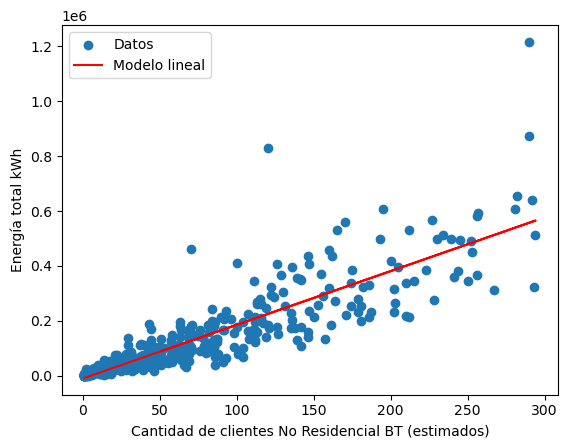

In [19]:
plt.scatter(X, y, label="Datos")
plt.plot(X, modelo_lineal.predict(X), color="red", label="Modelo lineal")
plt.xlabel("Cantidad de clientes No Residencial BT (estimados)")
plt.ylabel("Energía total kWh")
plt.legend()
plt.show()

##### Estimación de la Energía Consumida por clientes No Residenciales AT

In [20]:
# Se estima la energía consumida
df_caracterizacion_distribucion_estimacion = df_clientes_regulados_norm.copy()

df_train = df_caracterizacion_distribucion_estimacion[(df_caracterizacion_distribucion_estimacion["Energia_total_kwh"] >= 0) &
                                                      (df_caracterizacion_distribucion_estimacion["Tipo_clientes"] == "No Residencial AT") &
                                                      (df_caracterizacion_distribucion_estimacion["Cantidad_de_clientes"] < 1000)].copy()

X = df_train[["Cantidad_de_clientes"]].values
y = df_train["Energia_total_kwh"].values

# Se entrena el modelo
modelo_lineal = LinearRegression()
modelo_lineal.fit(X, y)

print("Coef clientes:", modelo_lineal.coef_[0])
print("Constante C:", modelo_lineal.intercept_)
print("R^2 (entrenamiento):", modelo_lineal.score(X, y))

# Se crea una nueva columna sobre la cantidad de clientes estimados con valores nulos
df_caracterizacion_distribucion_estimacion["Energia_total_kwh_estimada"] = np.nan

# Se establecen las filas a estimar (donde Cantidad_de_clientes == Nulo)
faltantes = df_caracterizacion_distribucion_estimacion[df_caracterizacion_distribucion_estimacion["Energia_total_kwh"].isna() & 
                                                       (df_caracterizacion_distribucion_estimacion["Tipo_clientes"] == "No Residencial AT")]
X_faltantes = df_caracterizacion_distribucion_estimacion.loc[faltantes.index, ["Cantidad_de_clientes"]].values

# Predicción y limpieza
y_prediccion = modelo_lineal.predict(X_faltantes)
y_prediccion = np.round(y_prediccion).astype(int)        # Deben ser enteros

# Se guarda en la nueva columna
df_caracterizacion_distribucion_estimacion.loc[faltantes.index, "Energia_total_kwh_estimada"] = y_prediccion

df_clientes_regulados_norm["Energia_total_kwh"] = (df_caracterizacion_distribucion_estimacion["Energia_total_kwh_estimada"]
                                                        .where(df_caracterizacion_distribucion_estimacion["Energia_total_kwh_estimada"] >= 0, 
                                                                df_caracterizacion_distribucion_estimacion["Energia_total_kwh"]))

df_clientes_regulados_norm

Coef clientes: 9709.06494906784
Constante C: -72328.09377048211
R^2 (entrenamiento): 0.6373925076595401


,Distribuidor,Comuna,Tipo_clientes,Tipo_de_facturacion,Cantidad_de_clientes,Energia_total_kwh,Densidad,Mapeo_Densidad
0,cec,chimbarongo,No Residencial AT,Mensual,9,50207.19,EXTREMADAMENTE BAJA,1
1,cec,chimbarongo,No Residencial BT,Mensual,1,4668.92,EXTREMADAMENTE BAJA,1
2,cec,chimbarongo,Residencial,Mensual,253,47719.28,EXTREMADAMENTE BAJA,1
3,cec,curico,No Residencial AT,Mensual,252,1891498.77,MUY BAJA,2
4,cec,curico,No Residencial BT,Mensual,104,197135.92,MUY BAJA,2
...,...,...,...,...,...,...,...,...
1429,chilquinta,la ligua,No Residencial BT,Bimensual,14,17373.00,EXTREMADAMENTE BAJA,1
1430,chilquinta,la ligua,No Residencial AT,Bimensual,17,92726.00,EXTREMADAMENTE BAJA,1
1431,coelcha,quilleco,Residencial,Bimensual,448,11085.00,EXTREMADAMENTE BAJA,1
1432,coelcha,quilleco,No Residencial BT,Bimensual,14,17373.00,EXTREMADAMENTE BAJA,1


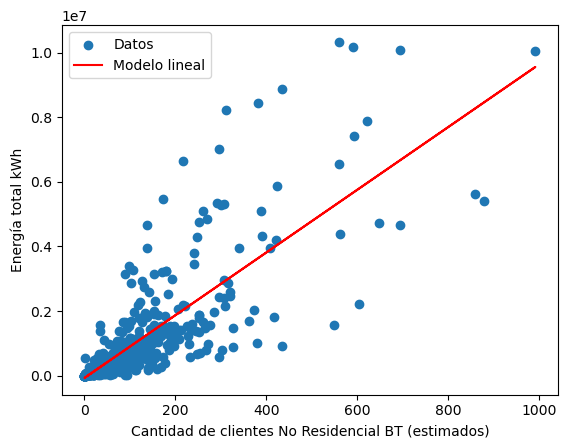

In [21]:
plt.scatter(X, y, label="Datos")
plt.plot(X, modelo_lineal.predict(X), color="red", label="Modelo lineal")
plt.xlabel("Cantidad de clientes No Residencial BT (estimados)")
plt.ylabel("Energía total kWh")
plt.legend()
plt.show()

### Resultados generales sobre Cantidad de Clientes y Energía Consumida

In [22]:
# Información al mes de diciembre de 2024
# -> Cantidad de clientes.
# -> Cantidad de energía.
cantidad_clientes_regulados = df_clientes_regulados_norm['Cantidad_de_clientes'].sum()
cantidad_energia_regulados = df_clientes_regulados_norm['Energia_total_kwh'].sum()

df_facturacion_clientes_residenciales = df_clientes_regulados_norm[df_clientes_regulados_norm['Tipo_clientes'] == 'Residencial']
cantidad_clientes_residenciales = df_facturacion_clientes_residenciales['Cantidad_de_clientes'].sum()
cantidad_energia_residenciales = df_facturacion_clientes_residenciales['Energia_total_kwh'].sum()

df_facturacion_clientes_no_residenciales = df_clientes_regulados_norm[df_clientes_regulados_norm['Tipo_clientes'] == 'No Residencial BT']
cantidad_clientes_no_residenciales_bt = df_facturacion_clientes_no_residenciales['Cantidad_de_clientes'].sum()
cantidad_energia_no_residenciales_bt = df_facturacion_clientes_no_residenciales['Energia_total_kwh'].sum()

df_facturacion_clientes_no_residenciales = df_clientes_regulados_norm[df_clientes_regulados_norm['Tipo_clientes'] == 'No Residencial AT']
cantidad_clientes_no_residenciales_at = df_facturacion_clientes_no_residenciales['Cantidad_de_clientes'].sum()
cantidad_energia_no_residenciales_at = df_facturacion_clientes_no_residenciales['Energia_total_kwh'].sum()

print("(A fecha de diciembre de 2024)",
      "\nClientes regulados:", 
      "\n -> Cantidad de clientes: {:,}".format(cantidad_clientes_regulados), 
      "\n -> Energía facturada: {:,} TWh".format((cantidad_energia_regulados / 1_000_000_000).round(2)),
      "\nClientes Residenciales:",
      "\n -> Cantidad de clientes: {:,}".format(cantidad_clientes_residenciales),
      "\n -> Energía facturada: {:,} TWh".format((cantidad_energia_residenciales / 1_000_000_000).round(2)),
      "\nClientes No Residenciales en BT:",
      "\n -> Cantidad de clientes: {:,}".format(cantidad_clientes_no_residenciales_bt),
      "\n -> Energía facturada: {:,} TWh".format((cantidad_energia_no_residenciales_bt / 1_000_000_000).round(2)),
      "\nClientes No Residenciales en AT:",
	  "\n -> Cantidad de clientes: {:,}".format(cantidad_clientes_no_residenciales_at),
	  "\n -> Energía facturada: {:,} TWh".format((cantidad_energia_no_residenciales_at / 1_000_000_000).round(2)))

(A fecha de diciembre de 2024) 
Clientes regulados: 
 -> Cantidad de clientes: 7,625,265 
 -> Energía facturada: 2.24 TWh 
Clientes Residenciales: 
 -> Cantidad de clientes: 7,426,521 
 -> Energía facturada: 1.37 TWh 
Clientes No Residenciales en BT: 
 -> Cantidad de clientes: 142,787 
 -> Energía facturada: 0.37 TWh 
Clientes No Residenciales en AT: 
 -> Cantidad de clientes: 55,957 
 -> Energía facturada: 0.5 TWh


### Se guardan los cambios realizados para su uso en *Caracterizacion_Dx_Dic2024_por_comuna-empresa(CNE).ipynb*

In [23]:
df_clientes_regulados_norm.to_excel("./Datos_Dx_procesados/BD final normalizada (procesados).xlsx", index=False)

## Pre-procesamiento de *df_perdidasdx*

El *'df_perdidasdx'* está hecho a partir de la información proporcionada por la Comisión Nacional de Energía a través del Anexo del cálculo del Precio Nudo Promedio (PNP). Los datos de consumo se encuentran actualizados a Julio del 2024.

Son los datos que serán usados para estimar las pérdidas de cada par comuna-empresa.

Fuente de los datos: [Página web CNE: Anexos PNP 2025](https://comisionenergia-my.sharepoint.com/personal/onedrive-subdeptargedis_cne_cl/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fonedrive%2Dsubdeptargedis%5Fcne%5Fcl%2FDocuments%2FPublicaciones%20WEB%2FPNP%2F2025%2D07%2FITD%2F3%2E%2DBalance%20Dx%2FConsolidado%20per%C3%ADodo%20jul22%2Djun24&ga=1) (Se utiliza la base 'Balance Dx - Julio 2025')

In [8]:
# Se carga la base de datos de pérdidas de la CNE
df_perdidasdx = pd.read_excel('./Datos_Dx/Perdidas.xlsx')

df_se_primaria = df_perdidasdx.drop(columns=["Unnamed: 3", "STX", "PNEP [$/kWh]", "AR [$/kWh]", "AR base [$/kWh]", "PNPP [$/kW/mes]", "Pérdidas P [%]", "Pérdidas E [%]"]).copy()

# Se eliminan algunas columnas que no son de interés
df_perdidasdx = df_perdidasdx.drop(columns=["S/E Primaria", "Unnamed: 3", "STX", "PNEP [$/kWh]", "AR [$/kWh]", "AR base [$/kWh]", "PNPP [$/kW/mes]", "Pérdidas P [%]"])
df_perdidasdx

# Demanda según la tabla de pérdidas
demanda = df_perdidasdx["Demanda [MWh]"].sum()
print("Demanda anual según tabla de pérdidas (TWh): {:,}".format((demanda / 1_000_000).round(2)))
print("Demanda mensual según tabla de pérdidas (TWh): {:,}".format((demanda / 12_000_000).round(2)))

Demanda anual según tabla de pérdidas (TWh): 14.41
Demanda mensual según tabla de pérdidas (TWh): 1.2


La demanda mensual que figura en la tabla de pérdidas coincide aproximadamente con la demanda Residencial.

In [9]:
# Se normaliza la columna Empresa y se corrigen ciertos errores de denominación
df_perdidasdx = df_perdidasdx.drop(columns=["Demanda [MWh]"])

# Se normalizan la columna Distribuidor
for col in ["Empresa"]:
    df_perdidasdx[col] = (df_perdidasdx[col].str.lower()                									# Se vuelve minúscula
                                                .apply(lambda x: ud.unidecode(x) if pd.notna(x) else x)     # Se eliminan acentos
                                                .str.strip())                                               # Se eliminan espacios en blanco
    
# Se reenombra al columa Empresa -> Distribuidor
df_perdidasdx = df_perdidasdx.rename(columns={"Empresa": "Distribuidor",
                                              "Pérdidas E [%]": "Pérdidas de energía [1/u]"})

# Se reenombran algunos errores de denominación de empresas
correcciones_empresas = {
    "cge distribucion": "cge",
	"colina": "electrica colina",
	"tiltil": "electrica til til",
	"luzandes": "luz andes",
	"luzlinares": "luz linares",
    "luzparral": "luz parral",
}

df_perdidasdx["Distribuidor"] = df_perdidasdx["Distribuidor"].replace(correcciones_empresas)

df_perdidasdx

,Distribuidor,Pérdidas de energía [1/u]
0,cec,0.02923
1,cec,0.02923
2,cec,0.02923
3,cge,0.02923
4,cge,0.02923
...,...,...
419,socoepa,0.01583
420,socoepa,0.01583
421,electrica til til,0.01617
422,electrica til til,0.01464


In [30]:
# Se determinan las comunas y empresas únicas en ambos dataframes y en las que difieren
# df_perdidasdx
empresa_clientes_unique = set(df_perdidasdx["Distribuidor"].unique())

# Empresas en los que difieren en ambos dataframes
empresas_distintas = empresa_par_unique.symmetric_difference(empresa_clientes_unique)

print(" Cantidad de Empresas evaluadas en df_perdidasdx: ", len(empresa_clientes_unique), 
      "\n Cantidad de Empresas existentes según NTCSD de la CNE: ", len(empresa_par_unique),
      "\n -> Cantidad de empresas distintas: ", len(empresas_distintas),
      "\n -> Empresas distintas: ", sorted(empresas_distintas))

# Se cambian las empresas mencionadas anteriormente por la denominación 'cge'
empresas_de_cge = {'conafe', 'elecda', 'eliqsa', 'emelari', 'emelat'}
df_perdidasdx.loc[df_perdidasdx["Distribuidor"].isin(empresas_de_cge), "Distribuidor"] = "cge"

# df_perdidasdx
empresa_clientes_unique = set(df_perdidasdx["Distribuidor"].unique())

# Empresas en los que difieren en ambos dataframes
empresas_distintas = empresa_par_unique.symmetric_difference(empresa_clientes_unique)

print("\n ---------------- Cambio de denominación de empresas ----------------",
	  "\n\n Cantidad de Empresas evaluadas en df_perdidasdx: ", len(empresa_clientes_unique), 
      "\n Cantidad de Empresas existentes según NTCSD de la CNE: ", len(empresa_par_unique),
      "\n -> Cantidad de empresas distintas: ", len(empresas_distintas),
      "\n -> Empresas distintas: ", sorted(empresas_distintas))

 Cantidad de Empresas evaluadas en df_perdidasdx:  31 
 Cantidad de Empresas existentes según NTCSD de la CNE:  28 
 -> Cantidad de empresas distintas:  7 
 -> Empresas distintas:  ['conafe', 'edelaysen', 'edelmag', 'elecda', 'eliqsa', 'emelari', 'emelat']

 ---------------- Cambio de denominación de empresas ---------------- 

 Cantidad de Empresas evaluadas en df_perdidasdx:  26 
 Cantidad de Empresas existentes según NTCSD de la CNE:  28 
 -> Cantidad de empresas distintas:  2 
 -> Empresas distintas:  ['edelaysen', 'edelmag']


La idea es tener un solo valor por empresa, tal que sea relativamente representativo para cada una de ellas. Esto se logra con el promedio simple entre las diferentes S/E Primarias para cada empresa estudiada.

In [31]:
# Se calcula el promedio de pérdidas por empresa
df_perdidasdx["Pérdidas de energía [1/u]"] = pd.to_numeric(df_perdidasdx["Pérdidas de energía [1/u]"], errors="coerce")
df_perdidasdx_norm = pd.DataFrame()

for empresa in empresa_clientes_unique:
    promedio_perdidas = (df_perdidasdx.loc[df_perdidasdx["Distribuidor"] == empresa, "Pérdidas de energía [1/u]"].mean()).astype(float).round(4)

    registro = {
        "Distribuidor": empresa,
        "Pérdidas de energía [1/u]": promedio_perdidas
    }

    df_perdidasdx_norm = pd.concat([df_perdidasdx_norm, pd.DataFrame([registro])], ignore_index=True)
    
df_perdidasdx_norm

,Distribuidor,Pérdidas de energía [1/u]
0,luz parral,0.0292
1,coopersol,0.0116
2,litoral,0.0162
3,saesa,0.0166
4,desa,0.0116
5,coopelan,0.0292
6,frontel,0.0292
7,socoepa,0.0158
8,eepa,0.0146
9,emelca,0.0162


### Se guardan los cambios realizados para su uso en *Caracterizacion_Dx_Dic2024_comuna-empresa(CNE).ipynb*

In [ ]:
df_perdidasdx_norm.to_excel("./Datos_Dx_procesados/Perdidas (procesados).xlsx", index=False)

## Pre-procesamiento de *df_hurto* y *df_comercial*

El '*df_hurto*' y el '*df_comercial*' está hecho a partir de la información proporcionada por la Comisión Nacional de Energía a través del Anexo 3-10 del cálculo del proceso VAD 2024-2028. Los datos de estas pérdidas se encuentran actualizados a Diciembre de 2022, sin embargo, se pueden extrapolar a 2024 a través del método de Regresión Lineal.

Un detalle relevante es que estos porcentajes de hurto están sobre las compras de energía de las empresas distribuidoras, **no** sobre las ventas.

Fuente de los datos: [Anexo 3-10, VAD 2024-2028](https://comisionenergia-my.sharepoint.com/personal/onedrive-subdeptargedis_cne_cl/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fonedrive%2Dsubdeptargedis%5Fcne%5Fcl%2FDocuments%2FPublicaciones%20WEB%2FVAD%2FVAD%202024%2D2028%2F02%20Informe%20T%C3%A9cnico%20Preliminar%2FATD1%2FAnexos%2FAnexo%203%2FAnexo%203%2D10%20P%C3%A9rdidas%20No%20T%C3%A9cnicas%2FHurto&viewid=f5258698%2D4137%2D4785%2Da047%2D925c3d159fd9&ga=1)

In [2]:
df_hurto = pd.read_excel('./Datos_Dx/Pérdidas No Técnicas (Hurto).xlsx', sheet_name='% Hurto')
df_comercial = pd.read_excel('./Datos_Dx/Pérdidas No Técnicas (Hurto).xlsx', sheet_name='% Comercial')

### Pre-procesamiento de *df_hurto*

In [ ]:
# Se aplica el método de regresión lineal para predecir los valores de hurto para el año 2025
columnas_año = [col for col in df_hurto.columns if 'Hurto' in col]
año = np.array([int(col.split()[1]) for col in columnas_año]).reshape(-1, 1)

predicciones_2025 = []

modelo = LinearRegression()

for i, row in df_hurto.iterrows():
    y = row[columnas_año].values.astype(float)

    modelo.fit(año, y)

    # Predecimos 2025
    pred_2025 = modelo.predict([[2025]])[0]
    
    predicciones_2025.append(pred_2025)
    
df_hurto['Hurto 2025 [%]'] = predicciones_2025

# Se corrigen los valores de hurto para la empresa EDELAYSEN, ENEL por valores poco representativos
df_hurto.loc[df_hurto['Empresa'] == "EDELAYSEN", 'Hurto 2025 [%]'] = df_hurto['Hurto 2022 [%]']
df_hurto.loc[df_hurto['Empresa'] == "ENEL", 'Hurto 2025 [%]'] = df_hurto['Hurto 2022 [%]']

# Se eliminan las columnas de Hurto de años anteriores
df_hurto = df_hurto.drop(columns=["Hurto 2014 [%]", "Hurto 2015 [%]", "Hurto 2016 [%]", "Hurto 2017 [%]",
								  "Hurto 2018 [%]", "Hurto 2019 [%]", "Hurto 2020 [%]", "Hurto 2021 [%]", 
                                  "Hurto 2022 [%]"])	

df_hurto = df_hurto.rename(columns={"Hurto 2025 [%]": "Hurto de energía [pu]"})
df_hurto["Hurto de energía [pu]"] = (df_hurto["Hurto de energía [pu]"]).round(4)

In [4]:
# Se normalizan la columna Distribuidor
for col in ["Empresa"]:
    df_hurto[col] = (df_hurto[col].str.lower()                									  # Se vuelve minúscula
                        			  .apply(lambda x: ud.unidecode(x) if pd.notna(x) else x)     # Se eliminan acentos
                                      .str.strip())                                               # Se eliminan espacios en blanco
    
# Se reenombra al columa Empresa -> Distribuidor
df_hurto = df_hurto.rename(columns={"Empresa": "Distribuidor"})

# Se reenombran algunos errores de denominación de empresas
correcciones_empresas = {
    "enel": "enel distribucion"
}

df_hurto["Distribuidor"] = df_hurto["Distribuidor"].replace(correcciones_empresas)
df_hurto

,Distribuidor,Hurto de energía [pu]
0,enel distribucion,0.0128
1,cge,0.0500
2,chilquinta,0.0769
3,saesa,0.0164
4,frontel,0.0510
5,edelaysen,0.0432
6,eepa,0.0115
7,cooprel,0.0250
8,cec,0.0388
9,copelec,0.0795


### Pre-procesamiento de *df_comercial*

In [6]:
# Se eliminan las columnas de PC de años anteriores
df_comercial = df_comercial.drop(columns=["PC 2014 [%]", "PC 2015 [%]", "PC 2016 [%]", "PC 2017 [%]",
								  "PC 2018 [%]", "PC 2019 [%]", "PC 2020 [%]", "PC 2021 [%]"])	

df_comercial = df_comercial.rename(columns={"PC 2022 [%]": "PC [pu]"})
df_comercial["PC [pu]"] = (df_comercial["PC [pu]"]).round(4)

In [7]:
# Se normalizan la columna Distribuidor
for col in ["Empresa"]:
    df_comercial[col] = (df_comercial[col].str.lower()                							  # Se vuelve minúscula
                        			  .apply(lambda x: ud.unidecode(x) if pd.notna(x) else x)     # Se eliminan acentos
                                      .str.strip())                                               # Se eliminan espacios en blanco
    
# Se reenombra al columa Empresa -> Distribuidor
df_comercial = df_comercial.rename(columns={"Empresa": "Distribuidor"})

# Se reenombran algunos errores de denominación de empresas
correcciones_empresas = {
    "enel": "enel distribucion"
}

df_comercial["Distribuidor"] = df_comercial["Distribuidor"].replace(correcciones_empresas)
df_comercial

,Distribuidor,PC [pu]
0,enel distribucion,0.0095
1,cge,0.0125
2,chilquinta,0.0074
3,saesa,0.0119
4,frontel,0.0183
5,edelaysen,0.0091
6,eepa,0.0355
7,cooprel,0.0700
8,cec,0.0094
9,copelec,0.0472


### Se guardan los cambios realizados para su uso en *Caracterizacion_Dx_Dic2024_comuna-empresa(CNE).ipynb*

In [29]:
df_hurto.to_excel("./Datos_Dx_procesados/Pérdidas No Técnicas (Hurto) (procesados).xlsx", index=False)
df_comercial.to_excel("./Datos_Dx_procesados/Pérdidas No Técnicas (Comercial) (procesados).xlsx", index=False)

## Pre-procesamiento de *df_transformadoresdx*

Fuente de los datos: [Anexos VAD 2024-2028](https://comisionenergia-my.sharepoint.com/personal/onedrive-subdeptargedis_cne_cl/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fonedrive%2Dsubdeptargedis%5Fcne%5Fcl%2FDocuments%2FPublicaciones%20WEB%2FVAD%2FVAD%202024%2D2028%2F02%20Informe%20T%C3%A9cnico%20Preliminar%2FATD1%2FAnexos%2FAnexo%204%2FAnexo%204%2D10%20SMMC&viewid=f5258698%2D4137%2D4785%2Da047%2D925c3d159fd9&ga=1)


In [6]:
df_transformadoresdx = pd.read_excel('./Datos_Dx/Cantidad_de_transformadores_por_empresadx.xlsx', index_col=0, engine='openpyxl')

In [ ]:
# Se eliminan los registros no correspondientes al año 2025
df_transformadoresdx = df_transformadoresdx.loc[df_transformadoresdx["AÑO"] == 2025, :]

# Se normalizan la columna Distribuidor
for col in ["DISTRIBUIDORA"]:
    df_transformadoresdx[col] = (df_transformadoresdx[col].str.lower()                						# Se vuelve minúscula
                                                .apply(lambda x: ud.unidecode(x) if pd.notna(x) else x)     # Se eliminan acentos
                                                .str.strip())                                               # Se eliminan espacios en blanco

# Se reenombra al columa DISTRIBUIDORA -> Distribuidor
df_transformadoresdx = df_transformadoresdx.rename(columns={"DISTRIBUIDORA": "Distribuidor"})

df_transformadoresdx

In [ ]:
df_transformadoresdx = df_transformadoresdx.drop(columns=["AÑO", "TRAFO", "CL-BT", "CL-MT", "CL-OTROS", "Transf-aéreos", "Transf-subte"])
df_transformadoresdx

In [ ]:
df_transformadoresdx = df_transformadoresdx.rename(columns={"MED TRIFASICO 1S": "UM3F 1S para TD",
                                                            "MED TRIFASICO 2S": "UM3F 2S para TD",
                                                            "MED MONOFASICO 1S": "UM1F 1S para TD"})

df_transformadoresdx

In [ ]:
df_transformadoresdx.to_excel("./Datos_Dx_procesados/Cantidad_de_transformadores_por_empresadx (procesados).xlsx", index=False)

## Pre-procesamiento de *df_superficies_por_comuna*

Fuente de los datos: 
 - [Anexo 4-1, VAD 2024-2028](https://comisionenergia-my.sharepoint.com/personal/onedrive-subdeptargedis_cne_cl/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fonedrive%2Dsubdeptargedis%5Fcne%5Fcl%2FDocuments%2FPublicaciones%20WEB%2FVAD%2FVAD%202024%2D2028%2F02%20Informe%20T%C3%A9cnico%20Preliminar%2FATD1%2FAnexos%2FAnexo%204%2FAnexo%204%2D1&viewid=f5258698%2D4137%2D4785%2Da047%2D925c3d159fd9&ga=1) Para df_superficies_por_comuna, como base de datos principal.
 - [Página web Las Comunas, datos del CENSO 2024](https://www.lascomunas.cl/datos/datos_nacionales.htm) Para df_superficies_censo, para complementar los datos faltantes en VAD 2024-2028

In [18]:
df_superficies_por_comuna = pd.read_excel('./Datos_Dx/Superficie efectiva por comuna.xlsx', sheet_name='Superficie efectiva por comuna')
df_superficies_censo = pd.read_excel('./Datos_Dx/Superficie por comuna.xlsx')
df_superficies_censo

,Región,Comuna,Superficie_km2
0,Arica y Parinacota,Arica,4799
1,Arica y Parinacota,Camarones,3927
2,Arica y Parinacota,Putre,5903
3,Arica y Parinacota,General Lagos,2244
4,Tarapacá,Alto Hospicio,573
...,...,...,...
339,Metropolitana,Talagante,126
340,Metropolitana,El Monte,118
341,Metropolitana,Isla de Maipo,189
342,Metropolitana,Padre Hurtado,81


In [19]:
# Se agrupan las comunas iguales y se suma el resto de parámetros
df_superficies_por_comuna = (df_superficies_por_comuna.groupby("Comuna", dropna=False, as_index=False)
													  .agg({"km2 Comuna": "first",
													  		"km2 cobertura": "sum",
                                                            "km red MT": "sum",
															"km red BT": "sum"}))

# Se normalizan la columna comuna del VAD
for col in ["Comuna"]:
    df_superficies_por_comuna[col] = (df_superficies_por_comuna[col].str.lower()                			# Se vuelve minúscula
                                                .apply(lambda x: ud.unidecode(x) if pd.notna(x) else x)     # Se eliminan acentos
                                                .str.strip())                                               # Se eliminan espacios en blanco
    
# Se normalizan la columna comuna del Censo
for col in ["Comuna"]:
    df_superficies_censo[col] = (df_superficies_censo[col].str.lower()                			# Se vuelve minúscula
                                                .apply(lambda x: ud.unidecode(x) if pd.notna(x) else x)     # Se eliminan acentos
                                                .str.strip())                                               # Se eliminan espacios en blanco

# Diccionario de errores de comunas -> correcciones
comunas = {
    "treguaco": "trehuaco",
    "coyhaique": "coihaique",
    "aysen": "aisen",
}

# Se corrigen los errores de tipografía
df_superficies_por_comuna["Comuna"] = df_superficies_por_comuna["Comuna"].replace(comunas)	
df_superficies_censo["Comuna"] = df_superficies_censo["Comuna"].replace(comunas)	

# Se mezclan ambos dataframes, la columna km2 Comuna se reemplaza por la del censo ya que contiene menos errores
df_superficies_por_comuna = df_superficies_por_comuna.merge(df_superficies_censo[["Comuna", "Superficie_km2"]], on="Comuna", how="left")
df_superficies_por_comuna.drop(columns=["km2 Comuna"], inplace=True)

df_superficies_por_comuna

,Comuna,km2 cobertura,km red MT,km red BT,Superficie_km2
0,alhue,33.75,88.366937,68.257696,845.0
1,alto biobio,15.25,41.413314,28.531563,2125.0
2,alto del carmen,51.75,187.921759,54.939257,5939.0
3,alto hospicio,22.50,100.630280,175.026003,573.0
4,ancud,341.00,745.638398,522.839057,1752.0
...,...,...,...,...,...
317,yumbel,296.75,763.265422,537.806427,727.0
318,yungay,191.50,532.740952,331.436222,824.0
319,zapallar,48.25,138.521687,125.941522,288.0
320,niquen,13.50,31.677430,25.845938,493.0


In [20]:
# Se observa si es que existen correlaciones entre las variables para estimar las superficies efectivas faltantes
df_superficies_por_comuna[["Superficie_km2", "km2 cobertura", "km red BT"]].corr()

,Superficie_km2,km2 cobertura,km red BT
Superficie_km2,1.000000,-0.060754,-0.065695
km2 cobertura,-0.060754,1.000000,0.715937
km red BT,-0.065695,0.715937,1.000000


In [21]:
# Se calcula el factor km2 cobertura / km2 Comuna promedio para estimar la cantidad de superficie cubierta en comunas faltantes
factor_promedio = df_superficies_por_comuna["km2 cobertura"] / df_superficies_por_comuna["Superficie_km2"]
factor_promedio.mean()

np.float64(0.28432283533938024)

In [22]:
# Se añaden manualmente las comunas que no se encuentra en df_superficies_por_comuna
# De momento se mantiene cada comuna con valores nulos en las métricas
# Para el caso de la Superficie cubierta, se estima con el factor promedio calculado anteriormente
nuevas = [
    {"Comuna": "algarrobo", "km2 cobertura": 176 * factor_promedio.mean(), "km red MT": np.nan, "km red BT": np.nan, "Superficie_km2": 176},
    {"Comuna": "cabo de hornos", "km2 cobertura": 21551 * factor_promedio.mean(), "km red MT": np.nan, "km red BT": np.nan, "Superficie_km2": 21551},
    {"Comuna": "el quisco", "km2 cobertura": 51 * factor_promedio.mean(), "km red MT": np.nan, "km red BT": np.nan, "Superficie_km2": 51},
    {"Comuna": "natales", "km2 cobertura": 49924 * factor_promedio.mean(), "km red MT": np.nan, "km red BT": np.nan, "Superficie_km2": 49924},
    {"Comuna": "porvenir", "km2 cobertura": 9707 * factor_promedio.mean(), "km red MT": np.nan, "km red BT": np.nan, "Superficie_km2": 9707},
    {"Comuna": "punta arenas", "km2 cobertura": 17846 * factor_promedio.mean(), "km red MT": np.nan, "km red BT": np.nan, "Superficie_km2": 17846},
    {"Comuna": "putre", "km2 cobertura": 5903 * factor_promedio.mean(), "km red MT": np.nan, "km red BT": np.nan, "Superficie_km2": 5903},
    {"Comuna": "torres del paine", "km2 cobertura": 6630 * factor_promedio.mean(), "km red MT": np.nan, "km red BT": np.nan, "Superficie_km2": 6630}
]

df_superficies_por_comuna = pd.concat([df_superficies_por_comuna, pd.DataFrame(nuevas)], ignore_index=True)

df_superficies_por_comuna

,Comuna,km2 cobertura,km red MT,km red BT,Superficie_km2
0,alhue,33.750000,88.366937,68.257696,845.0
1,alto biobio,15.250000,41.413314,28.531563,2125.0
2,alto del carmen,51.750000,187.921759,54.939257,5939.0
3,alto hospicio,22.500000,100.630280,175.026003,573.0
4,ancud,341.000000,745.638398,522.839057,1752.0
...,...,...,...,...,...
325,natales,14194.533231,NaN,NaN,49924.0
326,porvenir,2759.921763,NaN,NaN,9707.0
327,punta arenas,5074.025319,NaN,NaN,17846.0
328,putre,1678.357697,NaN,NaN,5903.0


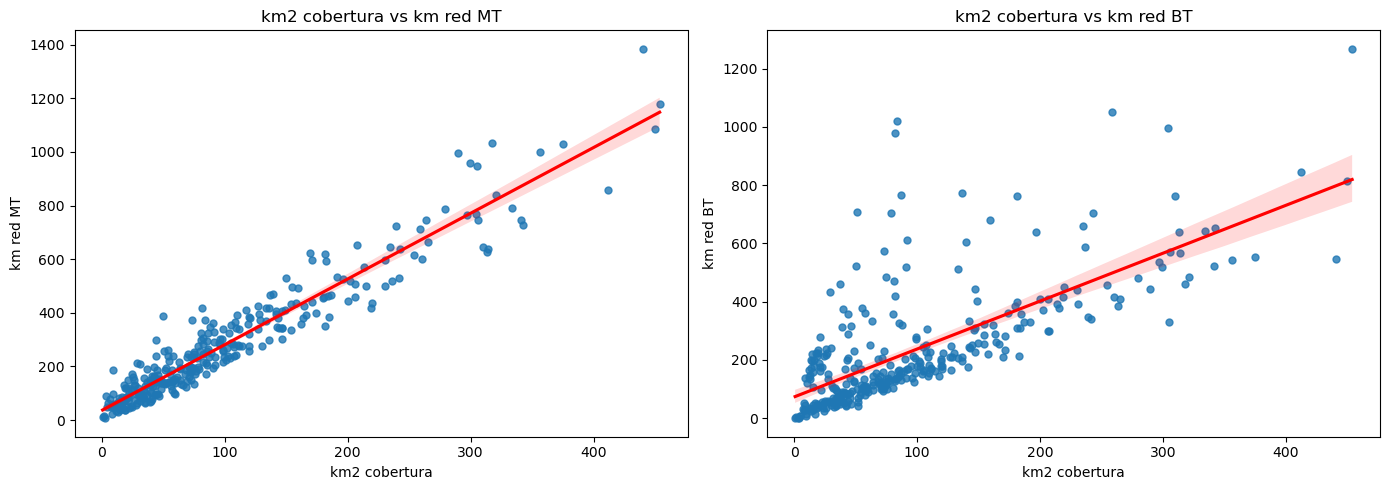

In [23]:
# Columnas de interés
x = "km2 cobertura"
y1 = "km red MT"
y2 = "km red BT"

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.regplot(
    data=df_superficies_por_comuna,
    x=x, y=y1,
    ax=axes[0],
    scatter_kws={"s": 25},
    line_kws={"color": "red"}
)
axes[0].set_title("km2 cobertura vs km red MT")
axes[0].set_xlabel("km2 cobertura")
axes[0].set_ylabel("km red MT")

sns.regplot(
    data=df_superficies_por_comuna,
    x=x, y=y2,
    ax=axes[1],
    scatter_kws={"s": 25},
    line_kws={"color": "red"}
)
axes[1].set_title("km2 cobertura vs km red BT")
axes[1].set_xlabel("km2 cobertura")
axes[1].set_ylabel("km red BT")

plt.tight_layout()
plt.show()

In [24]:
# Se estima la cantidad de clientes con el modelo de regresión lineal
df_superficies_estimacion = df_superficies_por_comuna.copy()

df_train = df_superficies_estimacion[(~df_superficies_estimacion["km red MT"].isna()) & 
                                     (~df_superficies_estimacion["km red BT"].isna())].copy()

X = df_train[["km2 cobertura"]].values
y_mt = df_train["km red MT"].values
y_bt = df_train["km red BT"].values

# Se entrena el modelo
modelo_lineal_mt = LinearRegression()
modelo_lineal_bt = LinearRegression()
modelo_lineal_mt.fit(X, y_mt)
modelo_lineal_bt.fit(X, y_bt)

print("Coef cobertura MT:", modelo_lineal_mt.coef_[0])
print("Coef cobertura BT:", modelo_lineal_bt.coef_[0])
print("Constante C MT:", modelo_lineal_mt.intercept_)
print("Constante C BT:", modelo_lineal_bt.intercept_)
print("R^2 (entrenamiento MT):", modelo_lineal_mt.score(X, y_mt))
print("R^2 (entrenamiento BT):", modelo_lineal_bt.score(X, y_bt))

# Se crea una nueva columna sobre la cantidad de clientes estimados con valores nulos
df_superficies_estimacion["km red MT estimados"] = np.nan
df_superficies_estimacion["km red BT estimados"] = np.nan

# Se establecen las filas a estimar (donde km red MT == Nulo)
faltantes_mt = df_superficies_estimacion["km red MT"].isna()
faltantes_bt = df_superficies_estimacion["km red BT"].isna()
X_faltantes_mt = df_superficies_estimacion.loc[faltantes_mt, ["km2 cobertura"]].values
X_faltantes_bt = df_superficies_estimacion.loc[faltantes_bt, ["km2 cobertura"]].values

# Predicción y limpieza
y_prediccion_mt = modelo_lineal_mt.predict(X_faltantes_mt)
y_prediccion_bt = modelo_lineal_bt.predict(X_faltantes_bt)

# Se guarda en la nueva columna
df_superficies_estimacion.loc[faltantes_mt, "km red MT estimados"] = y_prediccion_mt
df_superficies_estimacion.loc[faltantes_bt, "km red BT estimados"] = y_prediccion_bt

# Se rellenan las columnas originales con los valores originales y los estimados
df_superficies_estimacion["km red MT"] = (df_superficies_estimacion["km red MT"].where(~df_superficies_estimacion["km red MT"].isna(), 
                                                                            			df_superficies_estimacion["km red MT estimados"]))
df_superficies_estimacion["km red BT"] = (df_superficies_estimacion["km red BT"].where(~df_superficies_estimacion["km red BT"].isna(),
																						df_superficies_estimacion["km red BT estimados"]))

# Se eliminan las columnas de estimación
df_superficies_estimacion = df_superficies_estimacion.drop(columns=["km red MT estimados", "km red BT estimados"])

# Se modifican los nombres de las columnas
df_superficies_estimacion = df_superficies_estimacion.rename(columns={"km2 Comuna": "Superficie_km2",
                                                                      "km2 cobertura": "Superficie_efectiva_km2",
                                                                      "km red MT": "Largo_red_MT_km",
																	  "km red BT": "Largo_red_BT_km"})

df_superficies_por_comuna =df_superficies_estimacion.copy()

Coef cobertura MT: 2.4501964254034068
Coef cobertura BT: 1.6445204833647644
Constante C MT: 36.07119909437242
Constante C BT: 73.22413323918079
R^2 (entrenamiento MT): 0.9185477732802343
R^2 (entrenamiento BT): 0.5125661784060926


### Se guardan los cambios realizados para su uso en *Caracterizacion_Dx_Dic2024_comuna (CNE).ipynb*

In [25]:
df_superficies_por_comuna.to_excel("./Datos_Dx_procesados/Superficie por comuna (procesados).xlsx", index=False)